# DATA THINGS

## Import Libraries and Mount Google Drive

In [1]:
%%capture

from google.colab import drive
mount_folder_path = '/content/drive/'
drive.mount(mount_folder_path)

import os
import datetime
import torch
import logging
import imageio
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns

import xgboost
import shap

from dataclasses import dataclass
from typing import Dict, List, Tuple
from collections import Counter

import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer, LabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, r2_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, precision_recall_curve, PrecisionRecallDisplay, mean_absolute_error, auc, roc_curve, RocCurveDisplay, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

### Save Data into Dataframe



Show the downloaded files in the project folder.

In [2]:
# folder_path = '/content/drive/MyDrive/419a files/DO NOT CHANGE THE FILES IN HERE/'

# if os.path.exists(folder_path):
#   for item in os.listdir(folder_path):
#     print(f"{item:<40}")
# else:
#   print(f"The folder '{folder_path}' does not exist.")

Show oasis_cross-sectional-demographics.xlsx

In [3]:
cross_sectional_demographics_xlsx_path = '/content/drive/MyDrive/419a files/DO NOT CHANGE THE FILES IN HERE/oasis_cross-sectional-demographics.xlsx'

if os.path.exists(cross_sectional_demographics_xlsx_path):
  try:
    df = pd.read_excel(cross_sectional_demographics_xlsx_path)
    print(df.head())  # Show the first few rows of the DataFrame
  except Exception as e:
    print(f"Error reading Excel file: {e}")
else:
  print(f"The file '{cross_sectional_demographics_xlsx_path}' does not exist.")

              ID M/F  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  Delay
0  OAS1_0001_MR1   F   74   2.0  3.0  29.0  0.0  1344  0.743  1.306    NaN
1  OAS1_0002_MR1   F   55   4.0  1.0  29.0  0.0  1147  0.810  1.531    NaN
2  OAS1_0003_MR1   F   73   4.0  3.0  27.0  0.5  1454  0.708  1.207    NaN
3  OAS1_0004_MR1   M   28   NaN  NaN   NaN  NaN  1588  0.803  1.105    NaN
4  OAS1_0005_MR1   M   18   NaN  NaN   NaN  NaN  1737  0.848  1.010    NaN


## Data Analysis

Show Numerical, Categorical and Comprehensive summaries of the data

In [4]:
if os.path.exists(cross_sectional_demographics_xlsx_path):
  try:
    df = pd.read_excel(cross_sectional_demographics_xlsx_path)

    # Generate descriptive statistics for numerical columns
    numerical_summary = df.describe().round(2)

    # Count the number of unique values in categorical columns
    categorical_summary = df.select_dtypes(include=['object']).nunique()

    # Print the summaries
    print("\nNumerical Summary:\n", numerical_summary)
    print("\nCategorical Summary:\n", categorical_summary)

    # Create a more comprehensive summary table
    summary_table = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Unique Values': df.nunique(),
    })

    print("\nComprehensive Summary Table:\n", summary_table)

  except Exception as e:
    print(f"Error analyzing data: {e}")
else:
  print(f"The file '{cross_sectional_demographics_xlsx_path}' does not exist.")


Numerical Summary:
           Age    Educ     SES    MMSE     CDR     eTIV    nWBV     ASF  Delay
count  436.00  235.00  216.00  235.00  235.00   436.00  436.00  436.00  20.00
mean    51.36    3.18    2.49   27.06    0.29  1481.92    0.79    1.20  20.55
std     25.27    1.31    1.12    3.70    0.38   158.74    0.06    0.13  23.86
min     18.00    1.00    1.00   14.00    0.00  1123.00    0.64    0.88   1.00
25%     23.00    2.00    2.00   26.00    0.00  1367.75    0.74    1.11   2.75
50%     54.00    3.00    2.00   29.00    0.00  1475.50    0.81    1.19  11.00
75%     74.00    4.00    3.00   30.00    0.50  1579.25    0.84    1.28  30.75
max     96.00    5.00    5.00   30.00    2.00  1992.00    0.89    1.56  89.00

Categorical Summary:
 ID     436
M/F      2
dtype: int64

Comprehensive Summary Table:
       Data Type  Missing Values  Unique Values
ID       object               0            436
M/F      object               0              2
Age       int64               0             73


Show the counts of CDR values

In [5]:
df.value_counts(['CDR'])

,count
CDR,
0.0,135
0.5,70
1.0,28
2.0,2


## Code to extract all masked gain-field corrected transverse

In [6]:
# folder_path = '/content/drive/MyDrive/419a files/DO NOT CHANGE THE FILES IN HERE/oasis_cross-sectional_data/'

# df = pd.read_excel(cross_sectional_demographics_xlsx)
# subject_IDs = df['ID'].tolist()

# def find_extracted_files(root_folder, subject_IDs):
#     for subject_ID in subject_IDs:
#         target_folder = os.path.join(root_folder, str(subject_ID), "PROCESSED", "MPRAGE", "T88_111")
#         if os.path.exists(target_folder):
#             for root, _, files in os.walk(target_folder):
#                 for file in files:
#                     if "masked_gfc_tra_" in file:
#                         yield os.path.join(root, file)  # Yield full path immediately

# extracted_files = list(find_extracted_files(folder_path, subject_IDs))

# # # Print to verify (remove in actual use)
# # for extracted_file in extracted_files:
# #    print(extracted_file)

# # Copy files to a new directory
# import shutil

# output_folder = '/content/drive/MyDrive/419a files/extracted_files'  # Create this folder
# os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

# for file_path in extracted_files:
#     # Extract the filename from the full path
#     file_name = os.path.basename(file_path)

#     # Create the destination path
#     destination_path = os.path.join(output_folder, file_name)

#     # Copy the file to the destination
#     shutil.copy(file_path, destination_path)

## Data Cleaning

df_encoded = dataframe with gender numerically encoded, and missing CDR values assigned as 0 (normal)

In [7]:
df_encoded = df.copy()
# Numeric encoding of M/F
df_encoded = df_encoded.replace({'M': 0, 'F':1})
# Assign N/A CDR values as 0, decision was informed by the OASIS datasheet
df_encoded["CDR"]= df_encoded["CDR"].fillna(0.0)
df_encoded

<ipython-input-7-dc1c2df77187>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = df_encoded.replace({'M': 0, 'F':1})


,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,0,28,NaN,NaN,NaN,0.0,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,0,18,NaN,NaN,NaN,0.0,1737,0.848,1.010,NaN
...,...,...,...,...,...,...,...,...,...,...,...
431,OAS1_0285_MR2,0,20,NaN,NaN,NaN,0.0,1469,0.847,1.195,2.0
432,OAS1_0353_MR2,0,22,NaN,NaN,NaN,0.0,1684,0.790,1.042,40.0
433,OAS1_0368_MR2,0,22,NaN,NaN,NaN,0.0,1580,0.856,1.111,89.0
434,OAS1_0379_MR2,1,20,NaN,NaN,NaN,0.0,1262,0.861,1.390,2.0


<Axes: >

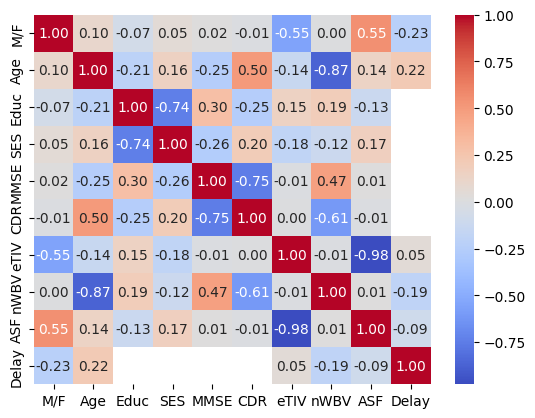

In [8]:
# Correlation matrix of all variables in dataframe except for ID
corr_matrix = df_encoded.drop("ID", axis = 1).corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

df_drop_cols = df_encoded with Delay, Education, Social Economic Status (SES), and MMSE dropped due to lot of NAs

In [9]:
df_drop_cols = df_encoded.drop(['Delay','Educ', 'SES', 'MMSE'], axis =1)
# extract features to predict
df_drop_cols_features = df_drop_cols.drop(['ID', 'CDR'], axis =1)

Correlation Matrix of df_drop_cols

<Axes: >

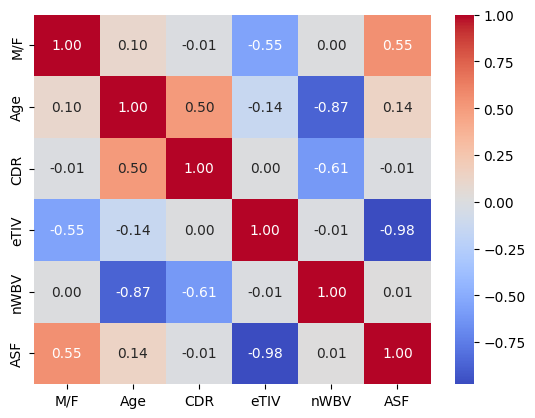

In [10]:
# Correlation matrix of variables present for all instances
corr_matrix = df_drop_cols.drop("ID", axis = 1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',fmt='.2f', cbar=True)

# FUNC: evaluate_model

Given a model and its data, this function returns the classification report, accuracies, F1 Score, MSE, and confusion matrix, as well as AUROC, AUPRC if applicable

In [11]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)

    # Get predictions
    y_pred = model.predict(X_test)

    # Get probability predictions
    y_proba = None
    try:
        y_proba = model.predict_proba(X_test)
    except AttributeError:
        print("Model doesn't support probability predictions")

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    train_acc = model.score(X_train, y_train)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Extended ROC AUC metrics
    roc_macro = roc_micro = roc_weighted = roc_ovo = None
    pr_macro = pr_micro = pr_weighted = None
    if y_proba is not None:
        try:
            # Different ROC AUC calculation methods
            roc_macro = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
            roc_micro = roc_auc_score(y_test, y_proba, multi_class='ovr', average='micro')
            roc_weighted = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
            roc_ovo = roc_auc_score(y_test, y_proba, multi_class='ovo')

            # Precision-Recall metrics
            pr_macro = average_precision_score(y_test, y_proba, average='macro')
            pr_micro = average_precision_score(y_test, y_proba, average='micro')
            pr_weighted = average_precision_score(y_test, y_proba, average='weighted')

        except ValueError as e:
            print(f"Error calculating ROC/PR metrics: {e}")
    else:
        print("Model doesn't support probability predictions")

    # Print all metrics
    print(f"\nBasic Metrics:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")

    if roc_macro:
        print(f"\nROC AUC Scores:")
        print(f"Macro One vs Rest: {roc_macro:.4f}")
        print(f"Micro One vs Rest: {roc_micro:.4f}")
        print(f"Weighted One vs Rest: {roc_weighted:.4f}")
        print(f"One vs One: {roc_ovo:.4f}")

        print(f"\nPrecision-Recall AUC Scores:")
        print(f"Macro Average: {pr_macro:.4f}")
        print(f"Micro Average: {pr_micro:.4f}")
        print(f"Weighted Average: {pr_weighted:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

# Basic Classification Models (Educ, SES, MMSE dropped)
Even the best KNN, with 32 neighbors, and Random Forest Classifier, with 3 estimators, are worse than Hist Gradient Boost model in training accuracy and f1-score. KNN does excel in testing accuracy by 3.14% points than the next best, Hist Gradient Boost.

## Data Setup

In [12]:
le = LabelEncoder()
le.fit(df_drop_cols["CDR"])
target_encoded = le.transform(df_drop_cols["CDR"])

"""
Split the data into training and testing sets.
(Experimented with stratification, but it removed class 3 in y_test,
so using without stratification, which brings back class 3)
"""
X_train, X_test, y_train, y_test = train_test_split(
    df_drop_cols_features,
    target_encoded,
    test_size=0.2,
    random_state=42,
    #stratify = target_encoded
)

print(df_drop_cols)

# Compare distributions in one line
print('Class distributions:\n', pd.DataFrame({
    'Original': df_drop_cols['CDR'].value_counts(normalize=True),
    'Train': pd.Series(y_train).value_counts(normalize=True),
    'Test': pd.Series(y_test).value_counts(normalize=True)
}).round(3))

                ID  M/F  Age  CDR  eTIV   nWBV    ASF
0    OAS1_0001_MR1    1   74  0.0  1344  0.743  1.306
1    OAS1_0002_MR1    1   55  0.0  1147  0.810  1.531
2    OAS1_0003_MR1    1   73  0.5  1454  0.708  1.207
3    OAS1_0004_MR1    0   28  0.0  1588  0.803  1.105
4    OAS1_0005_MR1    0   18  0.0  1737  0.848  1.010
..             ...  ...  ...  ...   ...    ...    ...
431  OAS1_0285_MR2    0   20  0.0  1469  0.847  1.195
432  OAS1_0353_MR2    0   22  0.0  1684  0.790  1.042
433  OAS1_0368_MR2    0   22  0.0  1580  0.856  1.111
434  OAS1_0379_MR2    1   20  0.0  1262  0.861  1.390
435  OAS1_0395_MR2    1   26  0.0  1283  0.834  1.368

[436 rows x 7 columns]
Class distributions:
      Original  Train   Test
0.0     0.771  0.767  0.784
0.5     0.161    NaN    NaN
1.0     0.064  0.170  0.125
2.0     0.005  0.060  0.080
3.0       NaN  0.003  0.011


## Hist Gradient Boost (Best)


Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.7614
F1 Score (weighted): 0.7374
MSE: 0.3750
MAE: 0.2841

ROC AUC Scores:
Macro One vs Rest: 0.7733
Micro One vs Rest: 0.9452
Weighted One vs Rest: 0.8661
One vs One: 0.5948

Precision-Recall AUC Scores:
Macro Average: 0.3915
Micro Average: 0.8847
Weighted Average: 0.8212

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        69
           1       0.31      0.36      0.33        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1

    accuracy                           0.76        88
   macro avg       0.29      0.32      0.31        88
weighted avg       0.72      0.76      0.74        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


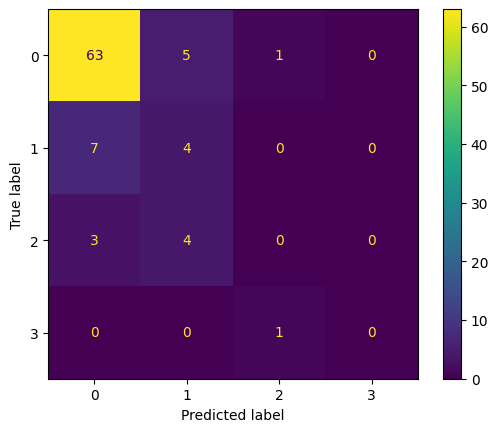

In [13]:
evaluate_model(
    HistGradientBoostingClassifier(random_state=42),
    X_train,
    y_train,
    X_test,
    y_test
    )

## KNN

Experiment to find the best n_neighbors for the K-Nearest Neighbors model, based on testing accuracy.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/li

Best parameters: {'n_neighbors': 32}

Basic Metrics:
Training Accuracy: 0.7644
Testing Accuracy: 0.7955
F1 Score (weighted): 0.7173
MSE: 0.5000
MAE: 0.2955

ROC AUC Scores:
Macro One vs Rest: 0.6602
Micro One vs Rest: 0.9296
Weighted One vs Rest: 0.7719
One vs One: 0.5822

Precision-Recall AUC Scores:
Macro Average: 0.3337
Micro Average: 0.8547
Weighted Average: 0.7781

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        69
           1       0.50      0.09      0.15        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1

    accuracy                           0.80        88
   macro avg       0.33      0.27      0.26        88
weighted avg       0.69      0.80      0.72        88



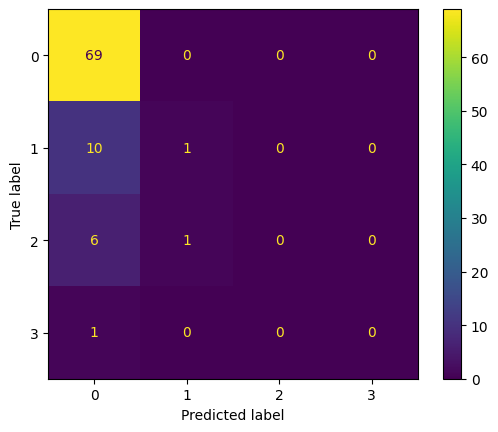

In [14]:
# Found that 32 is the best of 1-200 neighbors, so reduced range to save compute
param_grid = {'n_neighbors': range(30, 40)}
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
knn = KNeighborsClassifier()

# Grid search
grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1  # Use all CPU cores
)
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")

# Optional: evaluate with best model
evaluate_model(grid_search.best_estimator_, X_train, y_train, X_test, y_test)

## Random Forest Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'n_estimators': 3}

Basic Metrics:
Training Accuracy: 0.9511
Testing Accuracy: 0.7273
F1 Score (weighted): 0.7206
MSE: 0.4432
MAE: 0.3295

ROC AUC Scores:
Macro One vs Rest: 0.6729
Micro One vs Rest: 0.8956
Weighted One vs Rest: 0.8254
One vs One: 0.5684

Precision-Recall AUC Scores:
Macro Average: 0.3338
Micro Average: 0.7677
Weighted Average: 0.7792

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        69
           1       0.29      0.55      0.38        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1

    accuracy                           0.73        88
   macro avg       0.29      0.35      0.31        88
weighted avg       0.72      0.73      0.72        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


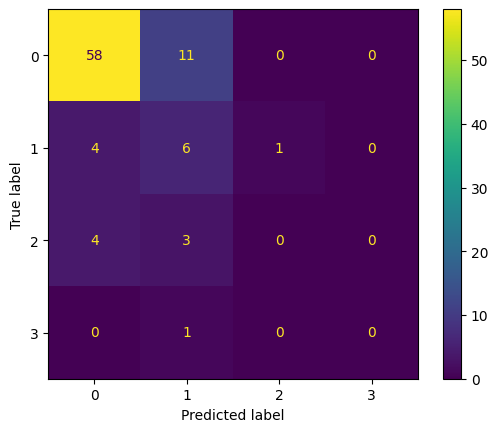

In [15]:
# Found that 3 is the best of 1-200 estimators, so reduced range to save compute
param_grid = {'n_estimators': range(1, 5)}
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
rfc = RandomForestClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    rfc,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1  # Use all CPU cores
)
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")

# Optional: evaluate with best model
evaluate_model(grid_search.best_estimator_, X_train, y_train, X_test, y_test)


Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.7273
F1 Score (weighted): 0.7170
MSE: 0.4432
MAE: 0.3295

ROC AUC Scores:
Macro One vs Rest: 0.7309
Micro One vs Rest: 0.9392
Weighted One vs Rest: 0.8502
One vs One: 0.5603

Precision-Recall AUC Scores:
Macro Average: 0.3639
Micro Average: 0.8676
Weighted Average: 0.8065

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88        69
           1       0.20      0.27      0.23        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1

    accuracy                           0.73        88
   macro avg       0.27      0.29      0.28        88
weighted avg       0.71      0.73      0.72        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


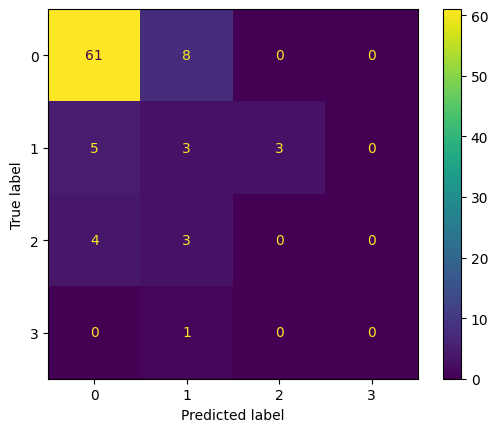

In [16]:
evaluate_model(RandomForestClassifier(random_state=42), X_train, y_train, X_test, y_test)

Experiment to find the best n_estimators for the Random Forest Classifier, based on testing accuracy.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'n_estimators': 193}

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.7273
F1 Score (weighted): 0.7175
MSE: 0.4432
MAE: 0.3295

ROC AUC Scores:
Macro One vs Rest: 0.7358
Micro One vs Rest: 0.9403
Weighted One vs Rest: 0.8537
One vs One: 0.5631

Precision-Recall AUC Scores:
Macro Average: 0.3702
Micro Average: 0.8705
Weighted Average: 0.8101

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        69
           1       0.24      0.36      0.29        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1

    accuracy                           0.73        88
   macro avg       0.28      0.31      0.29        88
weighted avg       0.71      0.73      0.72        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


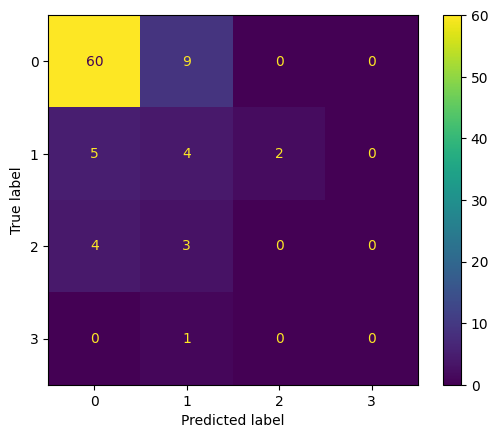

In [17]:
# Found out 198 is best from a range of 1 to 200,
# so reducing range to save compute
param_grid = {'n_estimators': range(190, 200)}
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
rfc = RandomForestClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    rfc,
    param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1  # Use all CPU cores
)
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")

# Optional: evaluate with best model
evaluate_model(grid_search.best_estimator_, X_train, y_train, X_test, y_test)

# Basic Classification Models (rows with NaN dropped) **//Exploration Only//**

Unscaled Logistic Regression model has the best testing accuracy and f1 score.

Scaled Logistic Regression model has the best training accuracy.

## Data Setup

In [18]:
# drop all rows with NA in columns Educ, SES,	MMSE. Left with 216 instances
df_dropped_rows = df_encoded.dropna(subset=['Educ', 'SES', 'MMSE'])
df_dropped_rows.loc[:, "Delay"] = df_dropped_rows["Delay"].fillna(0.0)
# df_dropped_rows = df_dropped_rows.drop(['Delay'], axis =1)
print(df_dropped_rows.shape)
df_dropped_features = df_dropped_rows.drop(columns = ["CDR", "ID"])

(216, 11)


In [19]:
# Using label encoder instead of Kbins

# enc = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform') # Create discretizer object
# target_discretized = enc.fit_transform(df_dropped[['CDR']]) # Fit and transform the target variable
# target_discretized = target_discretized.astype(int).ravel() # Convert to 1D array and convert to int

def dropped_classification(model):
  le = LabelEncoder()
  le.fit(df_dropped_rows["CDR"])
  target_encoded = le.transform(df_dropped_rows["CDR"])

  print(target_encoded)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(
      df_dropped_features, target_encoded, test_size=0.2, random_state=42
  )

  evaluate_model(model, X_train, y_train, X_test, y_test)

## Scaled Logistic

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 2 0 2 0 0 0 2 1 1 0 2 2 2 0 0 0 0 1 2 0 0 0 0
 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 2 1 0 0 2 0 2 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 2 2 0 0 1 1 0 2 0 0 0 1 1 1 0 1 2 0 0 1 0 1 0 0 1 1 3 0 1
 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 1 0
 1 0 1 0 2 1 1 0 0 2 2 0 0 2 1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0]
Error calculating ROC/PR metrics: Number of classes in y_true not equal to the number of columns in 'y_score'

Basic Metrics:
Training Accuracy: 0.7733
Testing Accuracy: 0.7500
F1 Score (weighted): 0.7465
MSE: 0.2500
MAE: 0.2500

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.40      0.44      0.42         9
           2       0.67      0.40      0.50         5

    accuracy                           0.75        44
   macro avg       0.65      0.58   

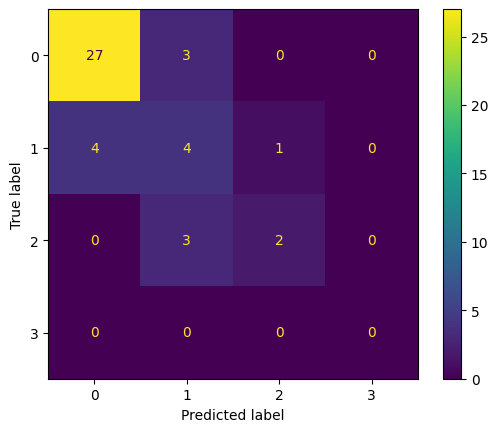

In [20]:
# Scaled logistic
dropped_classification(make_pipeline(StandardScaler(), LogisticRegression(random_state=42)))

## Unscaled Logistic Regression (Best)

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 2 0 2 0 0 0 2 1 1 0 2 2 2 0 0 0 0 1 2 0 0 0 0
 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 2 1 0 0 2 0 2 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 2 2 0 0 1 1 0 2 0 0 0 1 1 1 0 1 2 0 0 1 0 1 0 0 1 1 3 0 1
 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 1 0
 1 0 1 0 2 1 1 0 0 2 2 0 0 2 1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Error calculating ROC/PR metrics: Number of classes in y_true not equal to the number of columns in 'y_score'

Basic Metrics:
Training Accuracy: 0.7500
Testing Accuracy: 0.7727
F1 Score (weighted): 0.7585
MSE: 0.2273
MAE: 0.2273

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89        30
           1       0.43      0.33      0.38         9
           2       0.75      0.60      0.67         5

    accuracy                           0.77        44
   macro avg       0.68      0.62      0.64        44
weighted avg       0.75      0.77      0.76        44



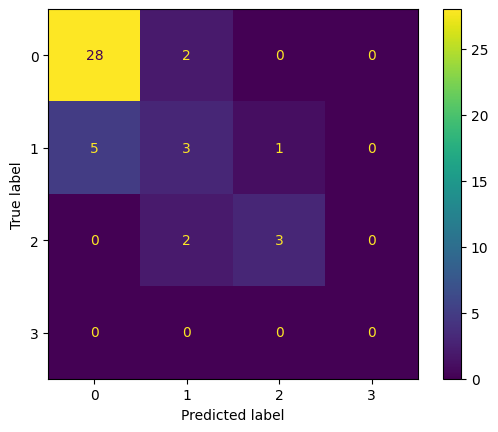

In [21]:
dropped_classification(LogisticRegression(random_state=42, max_iter=100000))

## Scaled Ridge

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 2 0 2 0 0 0 2 1 1 0 2 2 2 0 0 0 0 1 2 0 0 0 0
 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 2 1 0 0 2 0 2 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 2 2 0 0 1 1 0 2 0 0 0 1 1 1 0 1 2 0 0 1 0 1 0 0 1 1 3 0 1
 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 1 0
 1 0 1 0 2 1 1 0 0 2 2 0 0 2 1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0]
Model doesn't support probability predictions
Model doesn't support probability predictions

Basic Metrics:
Training Accuracy: 0.7209
Testing Accuracy: 0.6591
F1 Score (weighted): 0.5902
MSE: 0.3409
MAE: 0.3409

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        30
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         5

    accuracy                           0.66        44
   macro avg       0.26      0.32      0.29        44


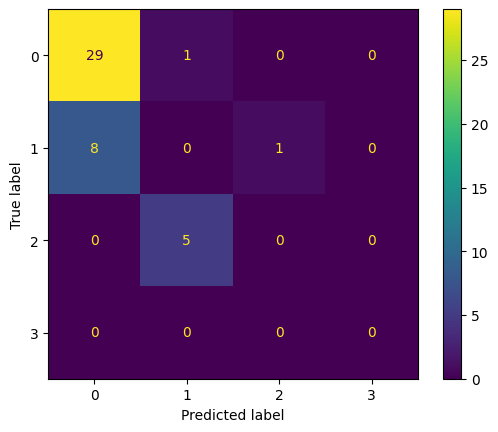

In [22]:
dropped_classification(make_pipeline(StandardScaler(), RidgeClassifier(random_state = 42)))

## Unscaled Ridge

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 2 0 2 0 0 0 2 1 1 0 2 2 2 0 0 0 0 1 2 0 0 0 0
 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 2 1 0 0 2 0 2 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 2 2 0 0 1 1 0 2 0 0 0 1 1 1 0 1 2 0 0 1 0 1 0 0 1 1 3 0 1
 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 1 0
 1 0 1 0 2 1 1 0 0 2 2 0 0 2 1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0]
Model doesn't support probability predictions
Model doesn't support probability predictions

Basic Metrics:
Training Accuracy: 0.7093
Testing Accuracy: 0.7273
F1 Score (weighted): 0.6844
MSE: 0.2727
MAE: 0.2727

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        30
           1       0.20      0.11      0.14         9
           2       1.00      0.40      0.57         5

    accuracy                           0.73        44
   macro avg       0.66      0.49      0.53        44


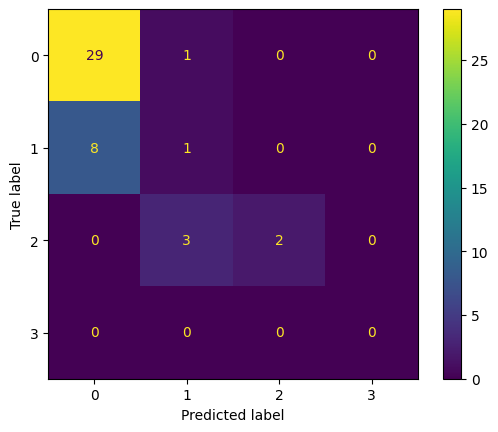

In [23]:
dropped_classification(RidgeClassifier(random_state = 42))

## Scaled KNN

[0 0 1 0 0 0 1 0 0 0 1 1 1 0 2 0 2 0 0 0 2 1 1 0 2 2 2 0 0 0 0 1 2 0 0 0 0
 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 2 1 0 0 2 0 2 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 2 2 0 0 1 1 0 2 0 0 0 1 1 1 0 1 2 0 0 1 0 1 0 0 1 1 3 0 1
 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 1 0
 1 0 1 0 2 1 1 0 0 2 2 0 0 2 1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0]
Error calculating ROC/PR metrics: Number of classes in y_true not equal to the number of columns in 'y_score'

Basic Metrics:
Training Accuracy: 0.7500
Testing Accuracy: 0.7045
F1 Score (weighted): 0.6904
MSE: 0.3636
MAE: 0.3182

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.33      0.33      0.33         9
           2       0.33      0.20      0.25         5

    accuracy                           0.70        44
   macro avg       0.50      0.48   

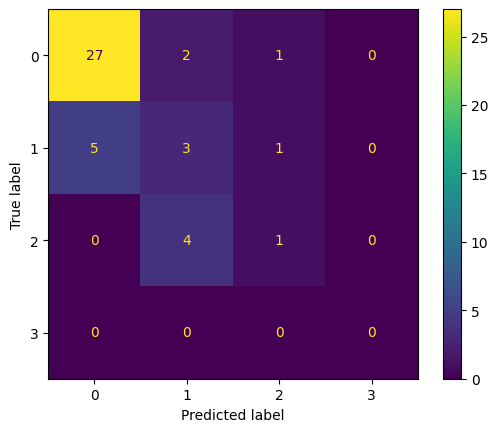

In [24]:
dropped_classification(make_pipeline(StandardScaler(), KNeighborsClassifier()))

## Unscaled KNN

Experiment to find out the best n_neighbors for KNN, based on testing accuracy.

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

def optimize_knn(features, target, max_k=30):
    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(target)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        features, y, test_size=0.2, random_state=42
    )

    # Setup and run grid search
    knn = KNeighborsClassifier()
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    grid = GridSearchCV(
        knn,
        {'n_neighbors': range(1, max_k+1)},
        cv=cv,
        scoring='accuracy'
    )

    grid.fit(X_train, y_train)

    # Print results
    print(f"Best k: {grid.best_params_['n_neighbors']}")
    print(f"Train accuracy: {grid.score(X_train, y_train):.3f}")
    print(f"Test accuracy: {grid.score(X_test, y_test):.3f}")

    return grid

# Usage
best_model = optimize_knn(df_dropped_features, df_dropped_rows["CDR"])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best k: 2
Train accuracy: 0.756
Test accuracy: 0.614


[0 0 1 0 0 0 1 0 0 0 1 1 1 0 2 0 2 0 0 0 2 1 1 0 2 2 2 0 0 0 0 1 2 0 0 0 0
 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 2 1 0 0 2 0 2 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 2 2 0 0 1 1 0 2 0 0 0 1 1 1 0 1 2 0 0 1 0 1 0 0 1 1 3 0 1
 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 1 0
 1 0 1 0 2 1 1 0 0 2 2 0 0 2 1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0]
Error calculating ROC/PR metrics: Number of classes in y_true not equal to the number of columns in 'y_score'

Basic Metrics:
Training Accuracy: 0.6977
Testing Accuracy: 0.6364
F1 Score (weighted): 0.5687
MSE: 0.5682
MAE: 0.4318

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79        30
           1       0.17      0.11      0.13         9
           2       0.00      0.00      0.00         5

    accuracy                           0.64        44
   macro avg       0.29      0.34   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

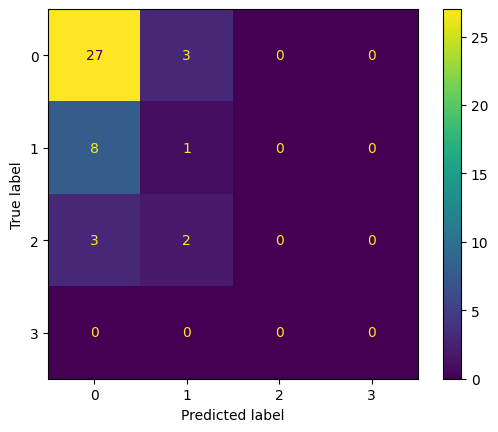

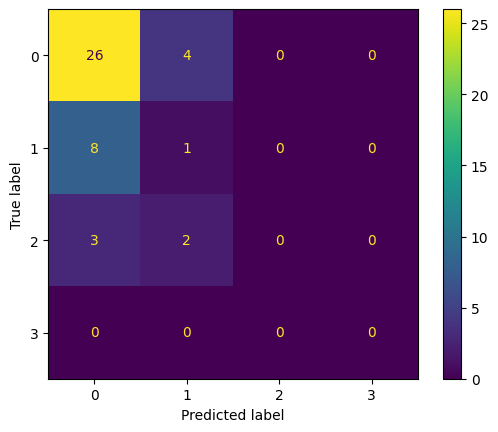

In [26]:
# default
dropped_classification(KNeighborsClassifier())
# best model
dropped_classification(KNeighborsClassifier(n_neighbors=2))

## Multi-layer Perceptron Classifier

Experiment to find out the best hidden_layer_sizes for MLP, based on testing accuracy.

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np
from typing import Tuple

def optimize_mlp(X_train: np.ndarray,
                X_test: np.ndarray,
                y_train: np.ndarray,
                y_test: np.ndarray) -> Tuple[dict, float, float]:
    """Optimize MLP classifier using grid search."""
    mlp = MLPClassifier(random_state=42)
    grid = GridSearchCV(
        mlp,
        {'hidden_layer_sizes': range(50, 70)}, ### Tried from 1 to 200, but 66 was still best. So, reducing range to save computation time
        cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
        scoring='accuracy',
        n_jobs=-1 # use all CPU cores
    )

    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    print(f"Train accuracy: {grid.score(X_train, y_train):.3f}")
    print(f"Test accuracy: {grid.score(X_test, y_test):.3f}")

    return grid.best_params_, grid.score(X_train, y_train), grid.score(X_test, y_test)

le = LabelEncoder()
le.fit(df_dropped_rows["CDR"])
target_encoded = le.transform(df_dropped_rows["CDR"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_dropped_features, target_encoded, test_size=0.2, random_state=42
)

# Usage
best_params, train_score, test_score = optimize_mlp(
    X_train, X_test, y_train, y_test
)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'hidden_layer_sizes': 66}
Train accuracy: 0.698
Test accuracy: 0.727


[0 0 1 0 0 0 1 0 0 0 1 1 1 0 2 0 2 0 0 0 2 1 1 0 2 2 2 0 0 0 0 1 2 0 0 0 0
 0 2 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 2 1 0 0 2 0 2 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 0 1 2 2 0 0 1 1 0 2 0 0 0 1 1 1 0 1 2 0 0 1 0 1 0 0 1 1 3 0 1
 2 0 0 0 0 1 0 0 1 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 0 2 1 0
 1 0 1 0 2 1 1 0 0 2 2 0 0 2 1 0 0 1 1 0 0 0 1 0 1 2 1 1 0 0 0]
Error calculating ROC/PR metrics: Number of classes in y_true not equal to the number of columns in 'y_score'

Basic Metrics:
Training Accuracy: 0.5988
Testing Accuracy: 0.6818
F1 Score (weighted): 0.5528
MSE: 0.6591
MAE: 0.4318

Classification Report:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        30
           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         5

    accuracy                           0.68        44
   macro avg       0.23      0.33   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

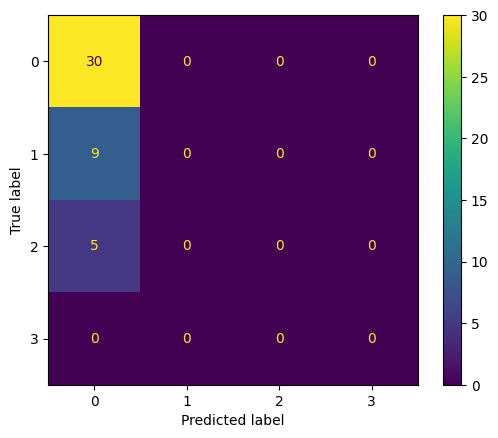

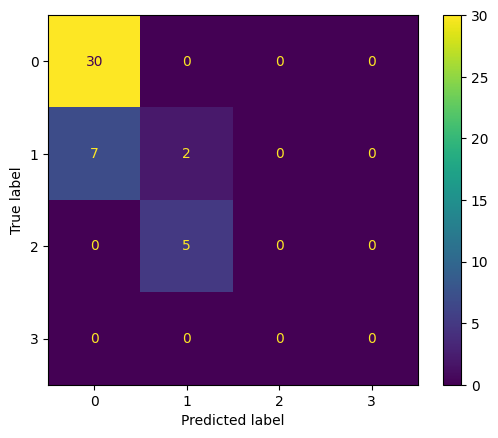

In [28]:
# default
dropped_classification(MLPClassifier(random_state=42))
# best MLP
dropped_classification(MLPClassifier(random_state=42, hidden_layer_sizes=66))

# XGBoost
This has the best performance on the demographics.

Investigated various methods: including all data without dropping missing values, imputing missing values with KNN, means, medians, modes, iteratively, and dropping Educ, MMSE, SES, Delay columns that had significant amount of missing data.

**Best model in all metrics: no drops, no imputation.**

Imputing values produced same performance as no imputation

## No Drops, No Imputation (Best)

X_train shape: (696, 9)
y_train shape: (696,)
X_test shape: (88, 9)
y_test shape: (88,)

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.8409
F1 Score (weighted): 0.8383
MSE: 0.1932
MAE: 0.1705

ROC AUC Scores:
Macro One vs Rest: 0.9536
Micro One vs Rest: 0.9799
Weighted One vs Rest: 0.9657
One vs One: 0.8388

Precision-Recall AUC Scores:
Macro Average: 0.7573
Micro Average: 0.9488
Weighted Average: 0.8938

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        69
           1       0.41      0.64      0.50        11
           2       0.67      0.29      0.40         7
           3       0.00      0.00      0.00         1

    accuracy                           0.84        88
   macro avg       0.51      0.47      0.46        88
weighted avg       0.85      0.84      0.84        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


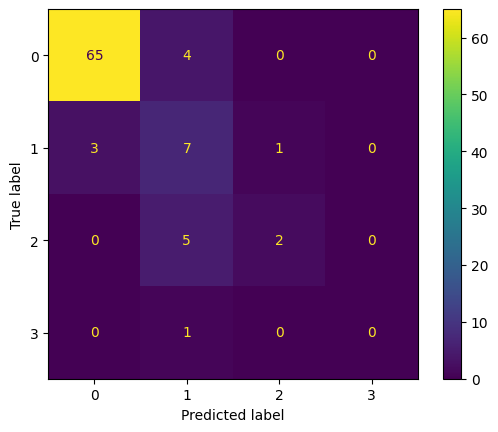

In [29]:
def preprocess_data(df_encoded):
    """Prepare features and target variables"""
    # Separate features and target
    df_features = df_encoded.drop(['ID', 'CDR'], axis=1)
    df_imputed_features = df_features
    # Encode target variable
    le = LabelEncoder()
    target_encoded = le.fit_transform(df_encoded["CDR"])

    return df_imputed_features, target_encoded

def split_and_augment_data(X, y, test_size=0.2, random_state=42, augment_factor=2):
    """Split data and perform data augmentation"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Augment data
    X_train = np.repeat(X_train, augment_factor, axis=0)
    y_train = np.repeat(y_train, augment_factor)

    return X_train, X_test, y_train, y_test

def train_xgb_model(X_train, y_train, params=None):
    """Train XGBoost model with given parameters"""
    if params is None:
        params = {
            'objective': 'multi:softmax',
            'num_class': 2,
            'eval_metric': 'mlogloss',
            'max_depth': 6
        }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Preprocess data
X, y = preprocess_data(df_encoded)

# Split and augment data
X_train, X_test, y_train, y_test = split_and_augment_data(X, y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Train model
model = train_xgb_model(X_train, y_train)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

## No Drops, KNN Imputation

X_train shape: (696, 9)
y_train shape: (696,)
X_test shape: (88, 9)
y_test shape: (88,)

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.8182
F1 Score (weighted): 0.8156
MSE: 0.2159
MAE: 0.1932

ROC AUC Scores:
Macro One vs Rest: 0.9559
Micro One vs Rest: 0.9792
Weighted One vs Rest: 0.9621
One vs One: 0.8071

Precision-Recall AUC Scores:
Macro Average: 0.7844
Micro Average: 0.9457
Weighted Average: 0.9026

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        69
           1       0.33      0.45      0.38        11
           2       0.50      0.29      0.36         7
           3       0.00      0.00      0.00         1

    accuracy                           0.82        88
   macro avg       0.44      0.42      0.42        88
weighted avg       0.82      0.82      0.82        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


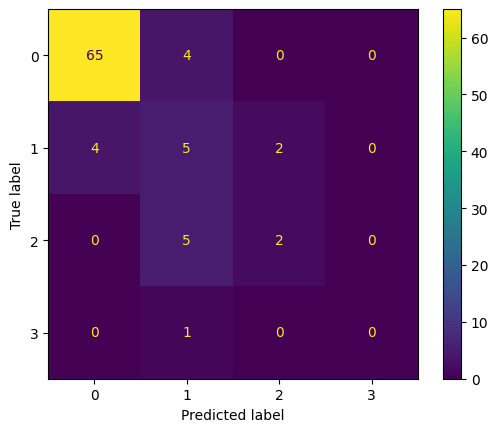

In [30]:
def preprocess_data_KNN(df_encoded):
    """Prepare features and target variables"""
    # Separate features and target
    df_features = df_encoded.drop(['ID', 'CDR'], axis=1)

    # Impute missing values using KNN
    imputer = KNNImputer(n_neighbors=4)
    df_imputed_features = imputer.fit_transform(df_features)

    # Encode target variable
    le = LabelEncoder()
    target_encoded = le.fit_transform(df_encoded["CDR"])

    return df_imputed_features, target_encoded

def split_and_augment_data(X, y, test_size=0.2, random_state=42, augment_factor=2):
    """Split data and perform data augmentation"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Augment data
    X_train = np.repeat(X_train, augment_factor, axis=0)
    y_train = np.repeat(y_train, augment_factor)

    return X_train, X_test, y_train, y_test

def train_xgb_model(X_train, y_train, params=None):
    """Train XGBoost model with given parameters"""
    if params is None:
        params = {
            'objective': 'multi:softmax',
            'num_class': 2,
            'eval_metric': 'mlogloss',
            'max_depth': 6
        }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Preprocess data
X, y = preprocess_data_KNN(df_encoded)

# Split and augment data
X_train, X_test, y_train, y_test = split_and_augment_data(X, y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Train model
model = train_xgb_model(X_train, y_train)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

## No Drops, Mean Imputation

X_train shape: (696, 9)
y_train shape: (696,)
X_test shape: (88, 9)
y_test shape: (88,)

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.8409
F1 Score (weighted): 0.8378
MSE: 0.1591
MAE: 0.1591

ROC AUC Scores:
Macro One vs Rest: 0.9510
Micro One vs Rest: 0.9791
Weighted One vs Rest: 0.9640
One vs One: 0.8232

Precision-Recall AUC Scores:
Macro Average: 0.7557
Micro Average: 0.9468
Weighted Average: 0.8944

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        69
           1       0.44      0.64      0.52        11
           2       0.50      0.29      0.36         7
           3       0.00      0.00      0.00         1

    accuracy                           0.84        88
   macro avg       0.47      0.47      0.46        88
weighted avg       0.84      0.84      0.84        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


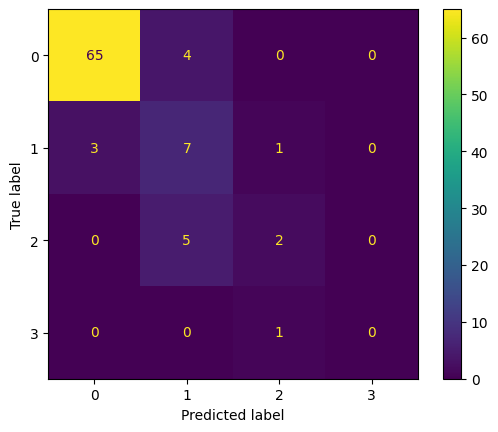

In [31]:
def preprocess_data_median(df_encoded):
    """Prepare features and target variables"""
    # Separate features and target
    df_features = df_encoded.drop(['ID', 'CDR'], axis=1)

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    df_imputed_features = imputer.fit_transform(df_features)

    # Encode target variable
    le = LabelEncoder()
    target_encoded = le.fit_transform(df_encoded["CDR"])

    return df_imputed_features, target_encoded

def split_and_augment_data(X, y, test_size=0.2, random_state=42, augment_factor=2):
    """Split data and perform data augmentation"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Augment data
    X_train = np.repeat(X_train, augment_factor, axis=0)
    y_train = np.repeat(y_train, augment_factor)

    return X_train, X_test, y_train, y_test

def train_xgb_model(X_train, y_train, params=None):
    """Train XGBoost model with given parameters"""
    if params is None:
        params = {
            'objective': 'multi:softmax',
            'num_class': 2,
            'eval_metric': 'mlogloss',
            'max_depth': 6
        }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Preprocess data
X, y = preprocess_data_median(df_encoded)

# Split and augment data
X_train, X_test, y_train, y_test = split_and_augment_data(X, y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Train model
model = train_xgb_model(X_train, y_train)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

## No Drops, Median Imputation

X_train shape: (696, 9)
y_train shape: (696,)
X_test shape: (88, 9)
y_test shape: (88,)

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.8182
F1 Score (weighted): 0.8152
MSE: 0.1818
MAE: 0.1818

ROC AUC Scores:
Macro One vs Rest: 0.9535
Micro One vs Rest: 0.9792
Weighted One vs Rest: 0.9666
One vs One: 0.8327

Precision-Recall AUC Scores:
Macro Average: 0.7525
Micro Average: 0.9464
Weighted Average: 0.8927

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        69
           1       0.36      0.45      0.40        11
           2       0.40      0.29      0.33         7
           3       0.00      0.00      0.00         1

    accuracy                           0.82        88
   macro avg       0.42      0.42      0.42        88
weighted avg       0.82      0.82      0.82        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


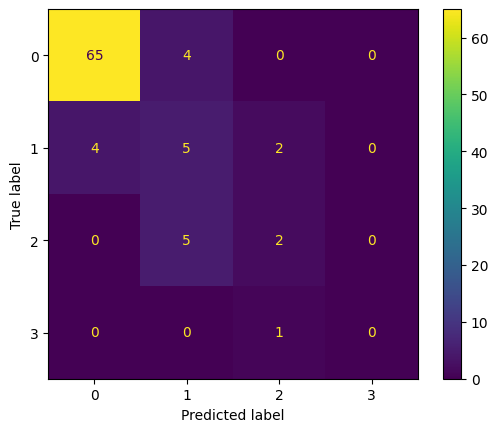

In [32]:
def preprocess_data_median(df_encoded):
    """Prepare features and target variables"""
    # Separate features and target
    df_features = df_encoded.drop(['ID', 'CDR'], axis=1)

    # Impute missing values using median
    imputer = SimpleImputer(strategy='median')
    df_imputed_features = imputer.fit_transform(df_features)

    # Encode target variable
    le = LabelEncoder()
    target_encoded = le.fit_transform(df_encoded["CDR"])

    return df_imputed_features, target_encoded

def split_and_augment_data(X, y, test_size=0.2, random_state=42, augment_factor=2):
    """Split data and perform data augmentation"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Augment data
    X_train = np.repeat(X_train, augment_factor, axis=0)
    y_train = np.repeat(y_train, augment_factor)

    return X_train, X_test, y_train, y_test

def train_xgb_model(X_train, y_train, params=None):
    """Train XGBoost model with given parameters"""
    if params is None:
        params = {
            'objective': 'multi:softmax',
            'num_class': 2,
            'eval_metric': 'mlogloss',
            'max_depth': 6
        }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Preprocess data
X, y = preprocess_data_median(df_encoded)

# Split and augment data
X_train, X_test, y_train, y_test = split_and_augment_data(X, y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Train model
model = train_xgb_model(X_train, y_train)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

## No Drops, Mode Imputation

X_train shape: (696, 9)
y_train shape: (696,)
X_test shape: (88, 9)
y_test shape: (88,)

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.8182
F1 Score (weighted): 0.8200
MSE: 0.1818
MAE: 0.1818

ROC AUC Scores:
Macro One vs Rest: 0.9542
Micro One vs Rest: 0.9802
Weighted One vs Rest: 0.9666
One vs One: 0.8443

Precision-Recall AUC Scores:
Macro Average: 0.7674
Micro Average: 0.9491
Weighted Average: 0.8983

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        69
           1       0.38      0.55      0.44        11
           2       0.40      0.29      0.33         7
           3       0.00      0.00      0.00         1

    accuracy                           0.82        88
   macro avg       0.43      0.44      0.43        88
weighted avg       0.83      0.82      0.82        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


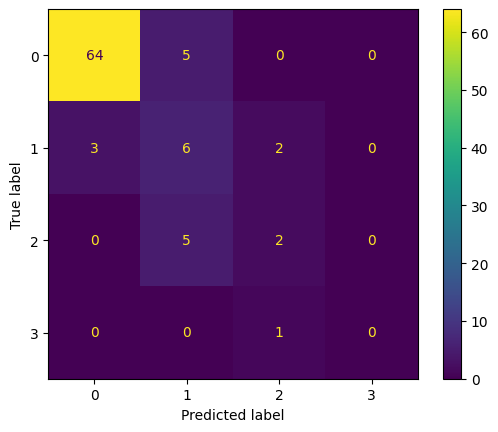

In [33]:
def preprocess_data_median(df_encoded):
    """Prepare features and target variables"""
    # Separate features and target
    df_features = df_encoded.drop(['ID', 'CDR'], axis=1)

    # Impute missing values
    imputer = SimpleImputer(strategy='most_frequent')
    df_imputed_features = imputer.fit_transform(df_features)

    # Encode target variable
    le = LabelEncoder()
    target_encoded = le.fit_transform(df_encoded["CDR"])

    return df_imputed_features, target_encoded

def split_and_augment_data(X, y, test_size=0.2, random_state=42, augment_factor=2):
    """Split data and perform data augmentation"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Augment data
    X_train = np.repeat(X_train, augment_factor, axis=0)
    y_train = np.repeat(y_train, augment_factor)

    return X_train, X_test, y_train, y_test

def train_xgb_model(X_train, y_train, params=None):
    """Train XGBoost model with given parameters"""
    if params is None:
        params = {
            'objective': 'multi:softmax',
            'num_class': 2,
            'eval_metric': 'mlogloss',
            'max_depth': 6
        }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Preprocess data
X, y = preprocess_data_median(df_encoded)

# Split and augment data
X_train, X_test, y_train, y_test = split_and_augment_data(X, y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Train model
model = train_xgb_model(X_train, y_train)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

## No Drops, Iterative Imputation

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


X_train shape: (696, 9)
y_train shape: (696,)
X_test shape: (88, 9)
y_test shape: (88,)

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.8409
F1 Score (weighted): 0.8383
MSE: 0.1932
MAE: 0.1705

ROC AUC Scores:
Macro One vs Rest: 0.9538
Micro One vs Rest: 0.9790
Weighted One vs Rest: 0.9658
One vs One: 0.8310

Precision-Recall AUC Scores:
Macro Average: 0.7693
Micro Average: 0.9470
Weighted Average: 0.9003

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95        69
           1       0.41      0.64      0.50        11
           2       0.67      0.29      0.40         7
           3       0.00      0.00      0.00         1

    accuracy                           0.84        88
   macro avg       0.51      0.47      0.46        88
weighted avg       0.85      0.84      0.84        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


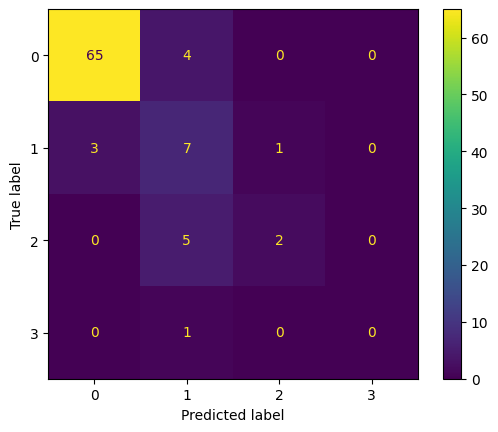

In [34]:
def preprocess_data_median(df_encoded):
    """Prepare features and target variables"""
    # Separate features and target
    df_features = df_encoded.drop(['ID', 'CDR'], axis=1)

    # Impute missing values using iterative imputation
    imputer = IterativeImputer(max_iter=1, random_state=42)
    df_imputed_features = imputer.fit_transform(df_features)

    # Encode target variable
    le = LabelEncoder()
    target_encoded = le.fit_transform(df_encoded["CDR"])

    return df_imputed_features, target_encoded

def split_and_augment_data(X, y, test_size=0.2, random_state=42, augment_factor=2):
    """Split data and perform data augmentation"""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Augment data
    X_train = np.repeat(X_train, augment_factor, axis=0)
    y_train = np.repeat(y_train, augment_factor)

    return X_train, X_test, y_train, y_test

def train_xgb_model(X_train, y_train, params=None):
    """Train XGBoost model with given parameters"""
    if params is None:
        params = {
            'objective': 'multi:softmax',
            'num_class': 2,
            'eval_metric': 'mlogloss',
            'max_depth': 6
        }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train, y_train)
    return model

# Preprocess data
X, y = preprocess_data_median(df_encoded)

# Split and augment data
X_train, X_test, y_train, y_test = split_and_augment_data(X, y)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Train model
model = train_xgb_model(X_train, y_train)

# Evaluate model
evaluate_model(model, X_train, y_train, X_test, y_test)

## Drop Educ, MMSE, SES, Delay

X_train shape: (348, 5)
y_train shape: (348,)
X_test shape: (88, 5)
y_test shape: (88,)

Basic Metrics:
Training Accuracy: 1.0000
Testing Accuracy: 0.7727
F1 Score (weighted): 0.7488
MSE: 0.3636
MAE: 0.2727

ROC AUC Scores:
Macro One vs Rest: 0.8581
Micro One vs Rest: 0.9486
Weighted One vs Rest: 0.8757
One vs One: 0.7034

Precision-Recall AUC Scores:
Macro Average: 0.4495
Micro Average: 0.8890
Weighted Average: 0.8393

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        69
           1       0.33      0.45      0.38        11
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         1

    accuracy                           0.77        88
   macro avg       0.30      0.34      0.32        88
weighted avg       0.73      0.77      0.75        88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


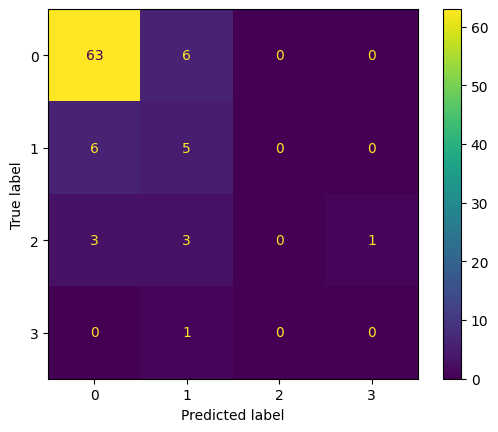

In [35]:
le = LabelEncoder()
le.fit(df_drop_cols["CDR"])
target_encoded = le.transform(df_drop_cols["CDR"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_drop_cols_features, target_encoded, test_size=0.2, random_state=42
)

# Print shapes for verification
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

model = xgboost.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', max_depth = 6)
evaluate_model(model, X_train, y_train, X_test, y_test)

# CNN for MRI Images

## Data setup for CNN


Gathers GIF data, aligns with CDR values, and optionally combines positive CDR values to make binary.

Then augments data, to nearly double the amount of data.

### Select Binary Mode

In [36]:
binary_mode = False # True for binary, False for multiclass

#### Pre-Data Augmentation

In [37]:
def load_gif_data(df, extracted_files_path, make_binary=False):
    """Loads GIF data and corresponding CDR values.

    Args:
        df: Pandas DataFrame with 'ID' and 'CDR' columns.
        extracted_files_path: Path to the directory containing GIF files.

    Returns:
        Tuple: (X, y) where X is a NumPy array of GIF arrays and y is a NumPy array of CDR values, or None if no data is found.
        Prints a warning if a GIF file is not found for a subject.
    """

    cdr_data = df[['ID', 'CDR']].set_index('ID')  # Set 'ID' as index for faster lookup

    gif_data = {}
    for subject_id, cdr_value in cdr_data.iterrows():
        cdr_value = cdr_value['CDR'] #access the value
        gif_file = next((f for f in os.listdir(extracted_files_path) if str(subject_id) in f), None) #ensure subject_id is a string
        if gif_file:
            gif_path = os.path.join(extracted_files_path, gif_file)
            try:
                gif = imageio.mimread(gif_path, format='gif')
                gif_array = np.array(gif)
                gif_data[subject_id] = {'gif_array': gif_array, 'cdr_value': cdr_value}
            except Exception as e: #catch and report any errors during file reading
                print(f"Error reading GIF file {gif_path}: {e}")
        else:
            print(f"Warning: No GIF file found for subject ID: {subject_id}")

    if not gif_data: #handle the case where no data was loaded
        print("No GIF data found.")
        return None

    gif_arrays = [data['gif_array'] for data in gif_data.values()]
    cdr_values = [data['cdr_value'] for data in gif_data.values()]

    cdr_values = [-1 if pd.isna(x) else x for x in cdr_values]

    # Map CDR values to be integers, and optionally binary
    if make_binary:
        mapping = {0: 0, 0.5: 1, 1: 1, 2: 1, -1: 0}
    else:
        mapping = {0: 0, 0.5: 1, 1: 2, 2: 3, -1: 0}

    cdr_values = np.array([mapping[val] for val in cdr_values])

    X = np.array(gif_arrays, dtype=object) #important for variable size gifs
    y = np.array(cdr_values)
    return X, y

extracted_files_path = '/content/drive/MyDrive/419a files/extracted_files'
X, y = load_gif_data(df, extracted_files_path, make_binary=binary_mode)

if X is not None: #only proceed if data was loaded
    # Split the data
    # Again, stratification removes the 3rd class, so stratification hasn't been implemented
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Handle variable GIF sizes by padding or resizing. Padding is shown here.
    max_shape = max(arr.shape for arr in X_train)
    X_train_padded = np.array([np.pad(arr, [(0, max_shape[i] - arr.shape[i]) for i in range(len(max_shape))]) for arr in X_train])
    max_shape = max(arr.shape for arr in X_test)
    X_test_padded = np.array([np.pad(arr, [(0, max_shape[i] - arr.shape[i]) for i in range(len(max_shape))]) for arr in X_test])

    # Reshape the data for the CNN (remove color channels data)
    # Adjust the reshape based on the structure of the GIF data
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[-1] if X_train.ndim == 5 else 1)
    X_test = X_test.reshape(X_test.shape[0], X_train.shape[1], X_test.shape[2], X_test.shape[3], X_test.shape[-1] if X_test.ndim == 5 else 1)

    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)
else:
    print("No data loaded.")

X_train shape: (348, 1, 208, 176, 1)
X_test shape: (88, 1, 208, 176, 1)
y_train shape: (348,)
y_test shape: (88,)


#### Data Augmentation


In [38]:
# Create an ImageDataGenerator instance with desired augmentation options
datagen = ImageDataGenerator(
    rotation_range=90,        # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.25,   # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.25,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.25,         # Randomly apply shearing transformations
    zoom_range=0.25,          # Randomly zoom inside pictures
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=True,       # Randomly flip images vertically
    fill_mode='nearest',      # Strategy for filling in newly created pixels
    rescale = 0.05           # Rescale the pixel values to be between 0 and 1
)

# Apply data augmentation to the training data
def augment_data(X, y, datagen, batch_size=32):
    """
    Augments the image data using the provided ImageDataGenerator.

    Args:
        X: NumPy array of image data.
        y: NumPy array of corresponding labels.
        datagen: ImageDataGenerator instance.
        batch_size: Batch size for generating augmented data.

    Returns:
        Augmented X and y data.
    """
    X_augmented = []
    y_augmented = []
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        for X_aug, y_aug in datagen.flow(X_batch, y_batch, batch_size=batch_size):
            X_augmented.extend(X_aug)
            y_augmented.extend(y_aug)
            break  # Only generate one batch of augmented data per original batch
    return np.array(X_augmented), np.array(y_augmented)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3], X_train.shape[4])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[3], X_test.shape[4])
# Augment the training data
X_train_augmented, y_train_augmented = augment_data(X_train, y_train, datagen)
X_test_augmented, y_test_augmented = augment_data(X_test, y_test, datagen)

# Concatenate the original and augmented data
X_train = np.concatenate((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))
X_test = np.concatenate((X_test, X_test_augmented))
y_test = np.concatenate((y_test, y_test_augmented))

# Add the removed dimension back
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3])  # Add the num_frames dimension
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3])  # Add the num_frames dimension

# Convert to floating numpy arrays
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

#### Dataset Shapes

In [39]:
# Datasets Shapes
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

# Unique values
print("Unique values in y_train: ", np.unique(y_train))
print("Unique values in y_test: ", np.unique(y_test))

X_train:  (696, 1, 208, 176, 1)
X_test:  (176, 1, 208, 176, 1)
y_train:  (696,)
y_test:  (176,)
Unique values in y_train:  [0 1 2 3]
Unique values in y_test:  [0 1 2 3]


# Concatenation

## Define the Full CNN Model

#### Building and Training the Model

Very computationally intensive. Use saved model.

Model building code commented out to skip during notebook execution.

In [40]:
# ########################
# #### BUILD THE MODEL ###
# ########################

# def create_model(input_shape, num_classes):
#     """Creates the CNN-GRU model."""
#     inputs = keras.Input(shape=input_shape)
#     regularizer = l1_l2(l1=0.001, l2=0.01)

#     processed = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))(inputs)
#     processed = TimeDistributed(BatchNormalization())(processed)
#     processed = TimeDistributed(MaxPooling2D((2, 2)))(processed)

#     processed = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))(processed)
#     processed = TimeDistributed(BatchNormalization())(processed)
#     processed = TimeDistributed(MaxPooling2D((2, 2)))(processed)

#     processed = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer))(processed)
#     processed = TimeDistributed(BatchNormalization())(processed)
#     processed = TimeDistributed(MaxPooling2D((2, 2)))(processed)

#     processed = TimeDistributed(Flatten())(processed)
#     processed = TimeDistributed(Dropout(0.5))(processed)

#     rnn_output = Bidirectional(keras.layers.GRU(128, dropout=0.5, kernel_regularizer=regularizer))(processed)
#     feature = Dense(num_classes, activation='softmax')(rnn_output)

#     model = keras.Model(inputs, feature)
#     return model

# def compute_class_weights(y):
#     """Computes class weights."""
#     classes, counts = np.unique(y, return_counts=True)
#     print(classes, counts)
#     class_weights = {}
#     total_samples = len(y)

#     for i, count in zip(classes, counts):
#         class_weights[i] = total_samples / (len(classes) * count)

#     print(class_weights)

#     return class_weights

# #######################
# ### K-Fold Training ###
# #######################

# def kfold_training(X, y, num_classes, n_splits=5, epochs=10, batch_size=32):
#     """Performs k-fold cross-validation."""
#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42) #added random_state for reproducibility
#     acc_per_fold = []
#     loss_per_fold = []
#     fold_no = 1

#     for train_index, test_index in kfold.split(X, y):
#         X_train_fold, X_test_fold = X[train_index], X[test_index]
#         y_train_fold, y_test_fold = y[train_index], y[test_index]
#         y_train_fold_categorical = tf.keras.utils.to_categorical(y_train_fold, num_classes=num_classes)
#         y_test_fold_categorical = tf.keras.utils.to_categorical(y_test_fold, num_classes=num_classes)

#         model = create_model(input_shape=X.shape[1:], num_classes=num_classes)
#         model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#         class_weights = compute_class_weights(y_train_fold)

#         reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-10)
#         callbacks = [
#             EarlyStopping(patience=5, restore_best_weights=True),
#             ModelCheckpoint(f'best_model_fold_{fold_no}_numclasses_{num_classes}.keras', save_best_only=True),
#             reduce_lr
#         ]

#         X_train_fold = X_train_fold.astype(np.float32)
#         X_val_fold = X_test_fold.astype(np.float32)
#         print(f"Training for fold {fold_no} ...")
#         history = model.fit(
#             X_train_fold, y_train_fold_categorical,
#             epochs=epochs,
#             batch_size=batch_size,
#             class_weight=class_weights,
#             validation_data=(X_test_fold, y_test_fold_categorical),
#             callbacks=callbacks
#         )

#         scores = model.evaluate(X_test_fold, y_test_fold_categorical, verbose=0)
#         print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#         acc_per_fold.append(scores[1] * 100)
#         loss_per_fold.append(scores[0])
#         fold_no += 1

#     # Print average scores
#     print('------------------------------------------------------------------------')
#     print('Score per fold')
#     print('------------------------------------------------------------------------')
#     for i in range(0, len(acc_per_fold)):
#         print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
#     print('------------------------------------------------------------------------')
#     print('Average scores for all folds:')
#     print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
#     print(f'> Loss: {np.mean(loss_per_fold)}')
#     print('------------------------------------------------------------------------')
#     return np.mean(acc_per_fold), np.mean(loss_per_fold)

# if binary_mode:
#     num_classes = 2
# else:
#     num_classes = 4

# # Example usage (assuming X_train, y_train, X_test, y_test, num_classes are defined):
# # average_accuracy, average_loss = kfold_training(X_train, y_train, num_classes, epochs=10)

# # After cross-validation, train on the full training set:
# final_model = create_model(X_train.shape[1:], num_classes)
# final_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)
# class_weights = compute_class_weights(y_train)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-10)
# callbacks = [
#             EarlyStopping(patience=5, restore_best_weights=True),
#             ModelCheckpoint(f'final_model_numclasses_{num_classes}.keras', save_best_only=True),
#             reduce_lr
#         ]
# X_train = X_train.astype(np.float32)
# X_test = X_test.astype(np.float32)
# final_model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, class_weight=class_weights, validation_data=(X_test, y_test_categorical), callbacks=callbacks)
# history_final_model = final_model.history.history

In [41]:
# # save the model
# final_model.save(f'/content/drive/MyDrive/419a files/cnn_model/final_model_{num_classes}.keras')
# # save history
# np.save(f'/content/drive/MyDrive/419a files/cnn_model/history_final_model_{num_classes}.npy', history_final_model)

#### Saved Model

In [42]:
if binary_mode:
    num_classes = 2
else:
    num_classes = 4

final_model_path = f'/content/drive/MyDrive/419a files/cnn_model/final_model_{num_classes}.keras'
history_final_model_path = f'/content/drive/MyDrive/419a files/cnn_model/history_final_model_{num_classes}.npy'

#load files
final_model = keras.models.load_model(final_model_path)
history_final_model = np.load(history_final_model_path, allow_pickle=True).item()

final_model.summary()

# print
for key, value in history_final_model.items():
    print(f'{key}: {value}')

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)          │ (None, 1, 208, 176, 1)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_368                 │ (None, 1, 208, 176, 32)     │             320 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_369                 │ (None, 1, 208, 176, 32)     │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_370                 │ (None, 1, 104, 88, 32)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_371                 │ (None, 1, 104, 88, 64)      │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_372                 │ (None, 1, 104, 88, 64)      │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_373                 │ (None, 1, 52, 44, 64)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_374                 │ (None, 1, 52, 44, 128)      │          73,856 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_375                 │ (None, 1, 52, 44, 128)      │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_376                 │ (None, 1, 26, 22, 128)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_377                 │ (None, 1, 73216)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_378                 │ (None, 1, 73216)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_34 (Bidirectional)     │ (None, 256)                 │      56,329,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,272,078 (645.72 MB)

 Trainable params: 56,423,876 (215.24 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 112,847,754 (430.48 MB)

accuracy: [0.42097702622413635, 0.5344827771186829, 0.477011501789093, 0.49425286054611206, 0.5818965435028076, 0.5201149582862854, 0.5617815852165222, 0.545976996421814, 0.5201149582862854, 0.5100574493408203, 0.5818965435028076, 0.647988498210907, 0.5862069129943848, 0.6537356376647949, 0.6278735399246216, 0.6149425506591797, 0.6580459475517273, 0.6781609058380127, 0.6393678188323975, 0.693965494632721, 0.6910919547080994, 0.6910919547080994, 0.681034505367279, 0.7169540524482727, 0.7356321811676025, 0.7514367699623108, 0.7485632300376892, 0.7068965435028076, 0.7701149582862854, 0.7787356376647949, 0.767241358757019, 0.7931034564971924, 0.8117815852165222, 0.8017241358757019, 0.8002873659133911, 0.8132184147834778, 0.767241358757019, 0.7988505959510803, 0.8232758641242981, 0.7974137663841248, 0.8017241358757019, 0.8390804529190063, 0.8376436829566956, 0.8275862336158752, 0.8204023241996765, 0.8103448152542114, 0.8563218116760254, 0.915229856967926, 0.9094827771186829, 0.9066091775894

Visual Representation of the model

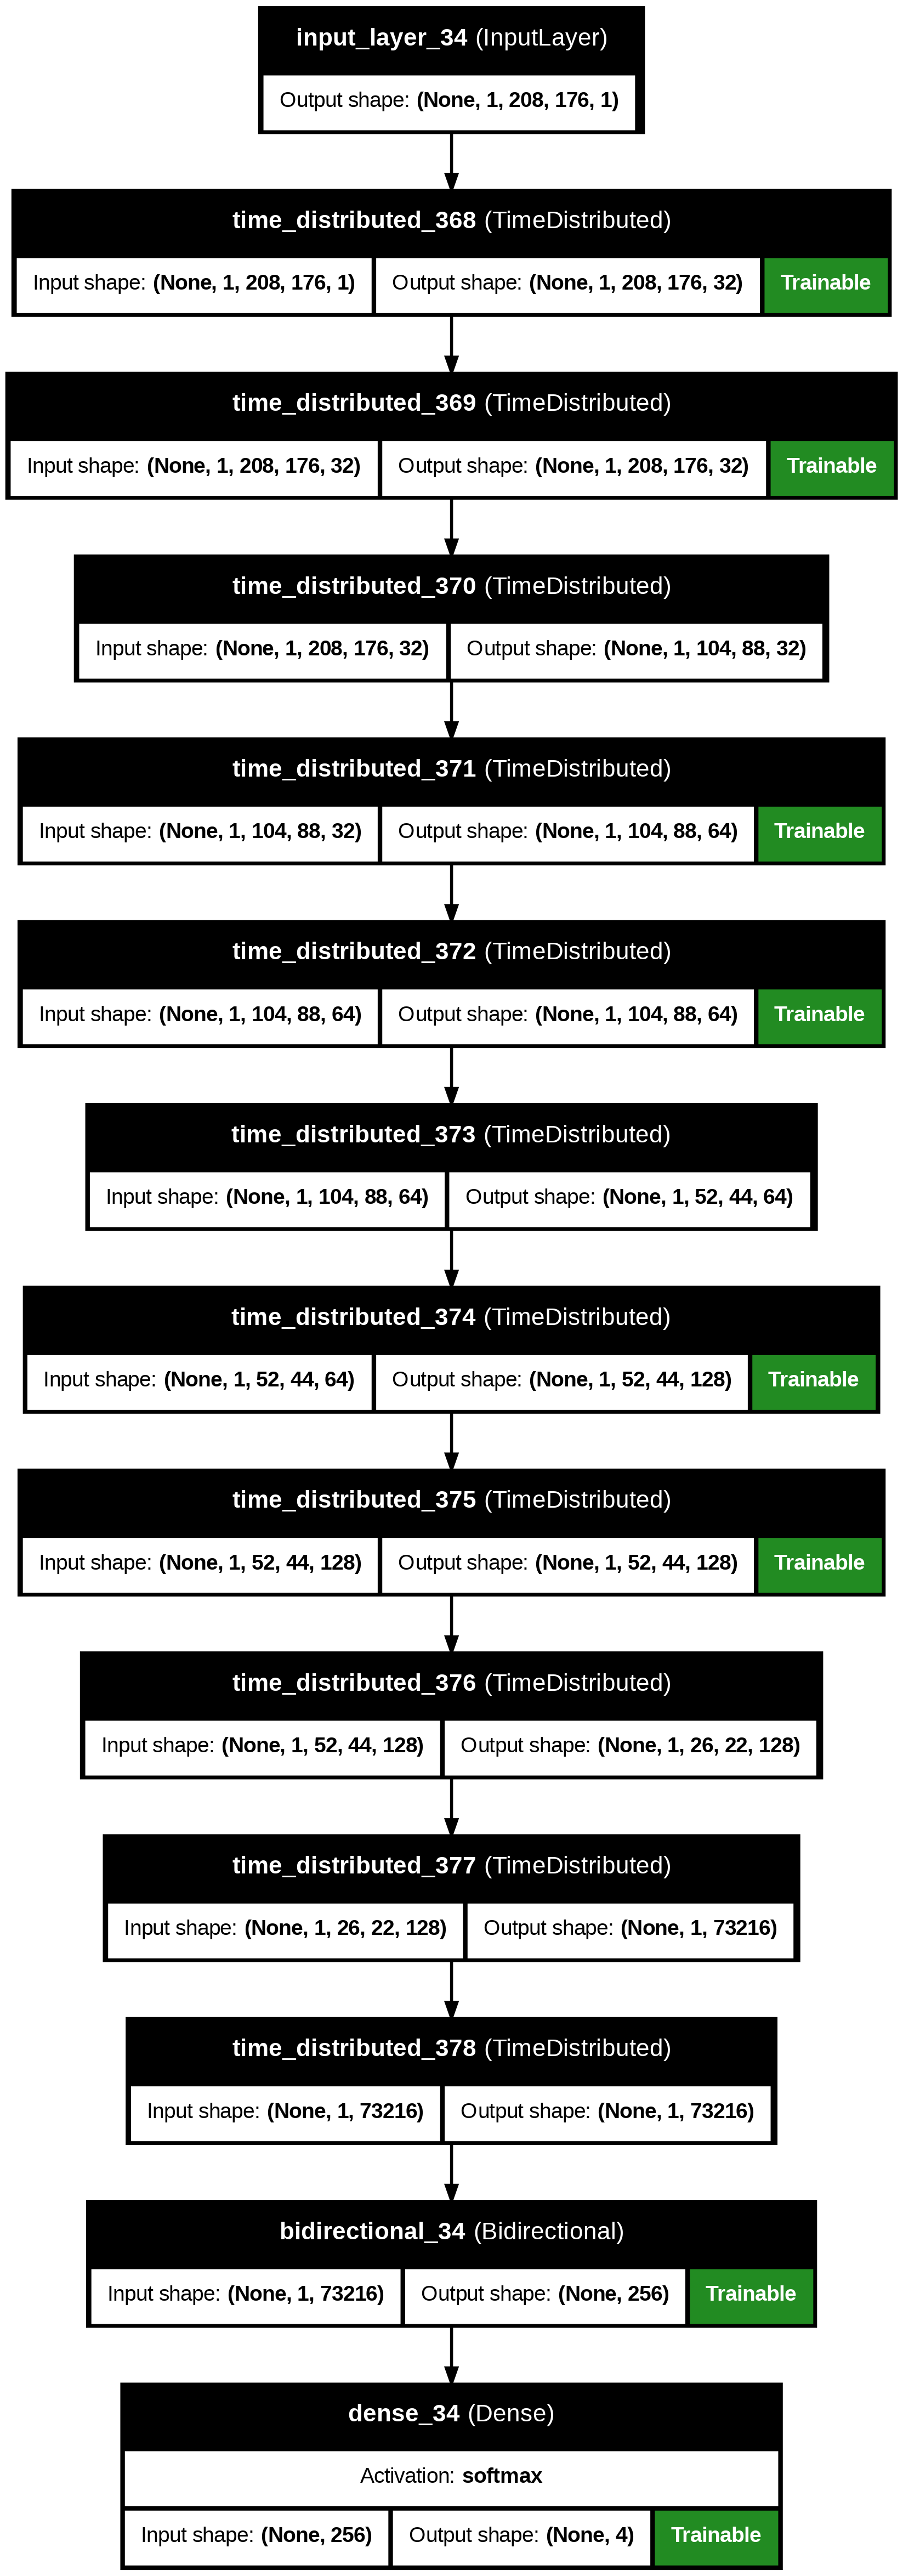

In [43]:
keras.utils.plot_model(final_model, to_file='/content/drive/MyDrive/419a files/cnn_model/final_model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True, rankdir='TB')

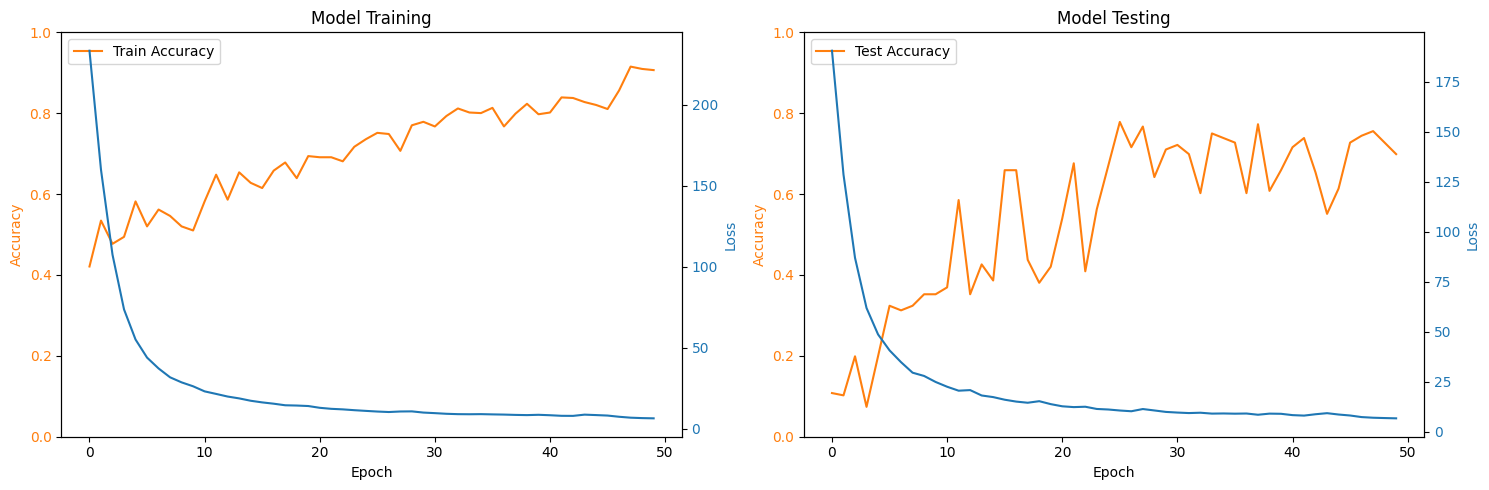

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step
AUROC: 0.75903423549726
AUPRC: 0.3991642508611354
MAE:  0.18979806895086684

Basic Metrics:
Training Accuracy: 0.9066
Testing Accuracy: 0.7330
F1 Score (weighted): 0.7453
MSE: 0.1335
MAE: 0.1898

ROC AUC Scores:
Macro One vs Rest: 0.7590
Micro One vs Rest: 0.9230
Weighted One vs Rest: 0.8235
One vs One: 0.6465

Precision-Recall AUC Scores:
Macro Average: 0.3992
Micro Average: 0.8339
Weighted Average: 0.8088

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       138
           1       0.27      0.45      0.34        22
           2       0.27      0.21      0.24        14
           3       0.00      0.00      0.00         2

   micro avg       0.73      0.73      0.73       176
   macro avg       0.36      0.38      0.36       176
weighted avg       0.77      0.73      0.75       176
 samples avg       0.73      0.73      0.73       176



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


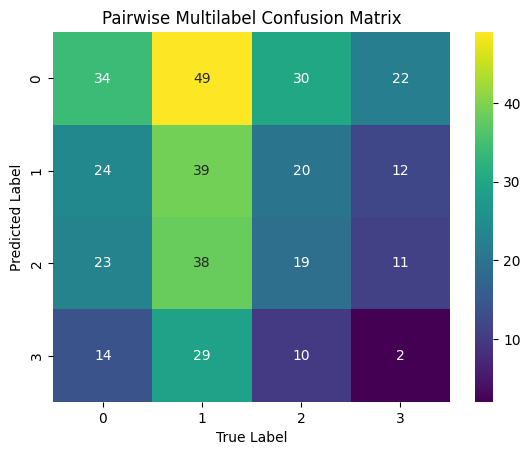

In [44]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

############
### PLOT ###
############
# plot accuracy and loss to figure out overfitting
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1 row, 2 columns of plots

# Training Plot
ax1 = axes[0]
color = 'tab:orange'
ax1.set_xlabel('Epoch')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(history_final_model['accuracy'], color=color, label='Train Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(history_final_model['loss'], color=color, label='Train Loss')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Model Training')

# Testing Plot
ax1 = axes[1]
color = 'tab:orange'
ax1.set_xlabel('Epoch')
ax1.set_ylim(0, 1)
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(history_final_model['val_accuracy'], color=color, label='Test Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(history_final_model['val_loss'], color=color, label='Test Loss')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Model Testing')

# Add legends
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

################
### EVALUATE ###
################

# Make predictions
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
#one-hot encode y_pred
y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=num_classes)

train_acc = history_final_model['accuracy'][-1]  # Get the last epoch's accuracy
acc = accuracy_score(y_test_categorical, y_pred)
f1 = f1_score(y_test_categorical, y_pred, average='weighted')
mse = mean_squared_error(y_test_categorical, y_pred)
mae = mean_absolute_error(y_test_categorical, y_pred)

auroc = roc_auc_score(y_test_categorical, y_pred_probs)
auprc = average_precision_score(y_test_categorical, y_pred_probs)
mae = mean_absolute_error(y_test_categorical, y_pred_probs)

roc_macro = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='macro')
roc_micro = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='micro')
roc_weighted = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')
roc_ovo = roc_auc_score(y_test, y_pred_probs, multi_class='ovo')

# Precision-Recall metrics
pr_macro = average_precision_score(y_test, y_pred_probs, average='macro')
pr_micro = average_precision_score(y_test, y_pred_probs, average='micro')
pr_weighted = average_precision_score(y_test, y_pred_probs, average='weighted')
print("AUROC:", auroc)
print("AUPRC:", auprc)
print("MAE: ", mae)

# Print all metrics
print(f"\nBasic Metrics:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

print(f"\nROC AUC Scores:")
print(f"Macro One vs Rest: {roc_macro:.4f}")
print(f"Micro One vs Rest: {roc_micro:.4f}")
print(f"Weighted One vs Rest: {roc_weighted:.4f}")
print(f"One vs One: {roc_ovo:.4f}")

print(f"\nPrecision-Recall AUC Scores:")
print(f"Macro Average: {pr_macro:.4f}")
print(f"Micro Average: {pr_micro:.4f}")
print(f"Weighted Average: {pr_weighted:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_categorical, y_pred))

from sklearn.metrics import multilabel_confusion_matrix

# Calculate confusion matrices for each label
mcm = multilabel_confusion_matrix(y_test_categorical, y_pred)

n_labels = len(mcm)
pairwise_cm = np.zeros((n_labels, n_labels))

for i in range(n_labels):
    for j in range(n_labels):
        pairwise_cm[i, j] = mcm[i][1, 0] + mcm[j][0, 1]  # FP of i + FN of j

plt.figure()
sns.heatmap(
    pairwise_cm,
    annot=True,
    cmap='viridis',
    xticklabels=range(n_labels),
    yticklabels=range(n_labels)
    )
plt.title('Pairwise Multilabel Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

## Redefine the XGBoost Model

X_train_xgb shape: (696, 9)
y_train_xgb shape: (696,)
X_test_xgb shape: (176, 9)
y_test_xgb shape: (176,)

Basic Metrics:
Training Accuracy: 0.8563
Testing Accuracy: 0.8750
F1 Score (weighted): 0.8660
MSE: 0.1250
MAE: 0.1250

ROC AUC Scores:
Macro One vs Rest: 0.9332
Micro One vs Rest: 0.9744
Weighted One vs Rest: 0.9288
One vs One: 0.8527

Precision-Recall AUC Scores:
Macro Average: 0.7490
Micro Average: 0.9240
Weighted Average: 0.8713

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       138
           1       0.56      0.45      0.50        22
           2       0.62      0.71      0.67        14
           3       0.00      0.00      0.00         2

    accuracy                           0.88       176
   macro avg       0.53      0.53      0.53       176
weighted avg       0.86      0.88      0.87       176



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


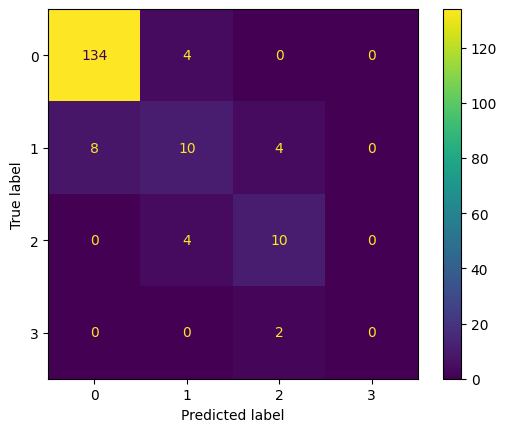

In [45]:
def preprocess_data(df_encoded):
    """Prepare features and target variables"""
    # Separate features and target
    df_features = df_encoded.drop(['ID', 'CDR'], axis=1)
    df_imputed_features = df_features
    # Encode target variable
    le = LabelEncoder()
    target_encoded = le.fit_transform(df_encoded["CDR"])

    return df_imputed_features, target_encoded

def split_and_augment_data(X, y, test_size=0.2, random_state=42, augment_factor=2):
    """Split data and perform data augmentation"""
    # Split the data
    X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Augment data
    X_train_xgb = np.repeat(X_train_xgb, augment_factor, axis=0)
    y_train_xgb = np.repeat(y_train_xgb, augment_factor)
    X_test_xgb = np.repeat(X_test_xgb, augment_factor, axis=0)
    y_test_xgb = np.repeat(y_test_xgb, augment_factor)

    return X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb

def train_xgb_model(X_train_xgb, y_train_xgb, params=None):
    """Train XGBoost model with given parameters"""
    if params is None:
        params = {
            'objective': 'multi:softmax',
            'num_class': len(set(y_train_xgb)),  # Dynamically determine num_classes
            'eval_metric': 'mlogloss',
            'max_depth': 1,
            'reg_alpha': 0,
            'reg_lambda': 0,
            'learning_rate': 1e-4,
        }

    model = xgboost.XGBClassifier(**params)
    model.fit(X_train_xgb, y_train_xgb)
    return model

import xgboost
from sklearn.model_selection import GridSearchCV

def grid_search_xgb(X_train_xgb, y_train_xgb):
    """Perform grid search to optimize XGBoost hyperparameters"""

    param_grid = {
        'learning_rate': [1e-4, 1e-3, 1e-2, 1e-1],
        'max_depth': range(1, 15),
        'reg_alpha': [0, 0.0001, 0.001, 0.01, 0.1],
        'reg_lambda': [0, 0.0001, 0.001, 0.01, 0.1]
    }

    model = xgboost.XGBClassifier(
        objective='multi:softmax',
        num_class=len(set(y_train_xgb)),
        eval_metric='mlogloss'
    )

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train_xgb, y_train_xgb)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best accuracy found: ", grid_search.best_score_)

    return grid_search.best_estimator_

# Preprocess data
X, y = preprocess_data(df_encoded)

# Split and augment data
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = split_and_augment_data(X, y)

# Print shapes for verification
print(f"X_train_xgb shape: {X_train_xgb.shape}")
print(f"y_train_xgb shape: {y_train_xgb.shape}")
print(f"X_test_xgb shape: {X_test_xgb.shape}")
print(f"y_test_xgb shape: {y_test_xgb.shape}")

# Train model
xgb_model = train_xgb_model(X_train_xgb, y_train_xgb)

# Evaluate model
evaluate_model(xgb_model, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb)

# # grid search
# best_model = grid_search_xgb(X_train_xgb, y_train_xgb)

# evaluate_model(best_model, X_train_xgb, y_train_xgb, X_test_xgb, y_test_xgb)

## Concatenation with XGBoost

In [46]:
# The CNN feature extractor model
def get_last_bidirectional_layer(model):
    for layer in reversed(model.layers):  # Iterate in reverse
        if isinstance(layer, tf.keras.layers.Bidirectional):
            return layer
    return None

bidirectional_layer = get_last_bidirectional_layer(final_model)
if bidirectional_layer:
    cnn_feature_extractor = keras.Model(
        inputs=final_model.input,
        outputs=bidirectional_layer.output
    )
else:
    print("No Bidirectional layer found!")

In [47]:
cnn_features_train = cnn_feature_extractor.predict(X_train)
cnn_features_test = cnn_feature_extractor.predict(X_test)
xgb_features_train = xgb_model.predict(X_train_xgb, output_margin=True)
xgb_features_test = xgb_model.predict(X_test_xgb, output_margin=True)

import scipy.special

xgb_features_train = scipy.special.expit(xgb_features_train)  # Apply sigmoid function
xgb_features_test = scipy.special.expit(xgb_features_test)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [48]:
# Concatenate
combined_features_train = np.concatenate((cnn_features_train, xgb_features_train), axis=1)
combined_features_test = np.concatenate((cnn_features_test, xgb_features_test), axis=1)

##### Logistic Regression Final Classifier

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Training Accuracy: 0.8807471264367817
Testing Accuracy: 0.75
AUROC: 0.728693772686579
AUPRC: 0.36469730843209336
MAE:  0.29545454545454547

Basic Metrics:
Training Accuracy: 0.9066
Testing Accuracy: 0.7500
F1 Score (weighted): 0.7176
MSE: 0.3977
MAE: 0.2955

ROC AUC Scores:
Macro One vs Rest: 0.7287
Micro One vs Rest: 0.9307
Weighted One vs Rest: 0.8207
One vs One: 0.5992

Precision-Recall AUC Scores:
Macro Average: 0.3647
Micro Average: 0.8474
Weighted Average: 0.7884

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       138
           1       0.19      0.23      0.21        22
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2

    accuracy                           0.75       176
   macro avg       0.26      0.29      0.27       176
weighted avg       0.69      0.75      0.72       176

Confusion Matrix:
 [[127  11   0   0]
 [ 17   5   0   0]
 [  5   9 

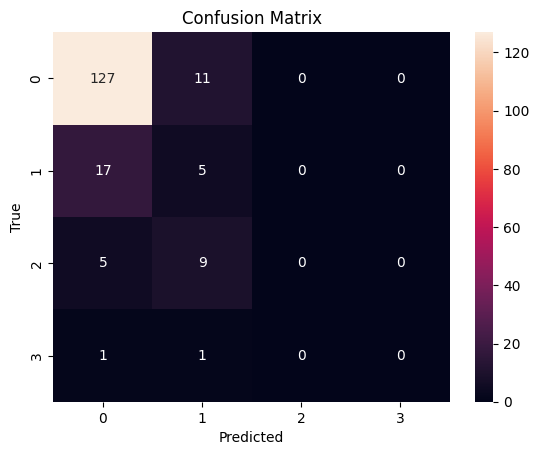

In [49]:
final_classifier = LogisticRegression()
final_classifier.fit(combined_features_train, y_train)

y_pred = final_classifier.predict(combined_features_test)
y_pred_probs = final_classifier.predict_proba(combined_features_test)

# y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

#Training accuracy
y_train_categorical_1d = y_train_categorical[:, 1]
train_accuracy = final_classifier.score(combined_features_train,
y_train_categorical_1d)

print(f'Training Accuracy: {train_accuracy}')

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Testing Accuracy: {accuracy}')

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

auroc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
auprc = average_precision_score(y_test, y_pred_probs)

roc_macro = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='macro')
roc_micro = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='micro')
roc_weighted = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')
roc_ovo = roc_auc_score(y_test, y_pred_probs, multi_class='ovo')

# Precision-Recall metrics
pr_macro = average_precision_score(y_test, y_pred_probs, average='macro')
pr_micro = average_precision_score(y_test, y_pred_probs, average='micro')
pr_weighted = average_precision_score(y_test, y_pred_probs, average='weighted')
print("AUROC:", auroc)
print("AUPRC:", auprc)
print("MAE: ", mae)

# Print all metrics
print(f"\nBasic Metrics:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

print(f"\nROC AUC Scores:")
print(f"Macro One vs Rest: {roc_macro:.4f}")
print(f"Micro One vs Rest: {roc_micro:.4f}")
print(f"Weighted One vs Rest: {roc_weighted:.4f}")
print(f"One vs One: {roc_ovo:.4f}")

print(f"\nPrecision-Recall AUC Scores:")
print(f"Macro Average: {pr_macro:.4f}")
print(f"Micro Average: {pr_micro:.4f}")
print(f"Weighted Average: {pr_weighted:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n {cm}')

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.title('Confusion Matrix')
plt.show()

##### Neural Network Final Classifier

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.4918 - loss: 6.3573 - val_accuracy: 0.7841 - val_loss: 5.5144
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7730 - loss: 5.2780 - val_accuracy: 0.7841 - val_loss: 4.7247
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7857 - loss: 4.5544 - val_accuracy: 0.7955 - val_loss: 4.1154
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8037 - loss: 3.8930 - val_accuracy: 0.7955 - val_loss: 3.5965
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7870 - loss: 3.4336 - val_accuracy: 0.7898 - val_loss: 3.1635
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8147 - loss: 2.9475 - val_accuracy: 0.7898 - val_loss: 2.7810
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8192 - loss: 2.5864 - val_accuracy: 0.7500 - val_loss: 2.4661
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8617 - loss: 2.1934 - val_accuracy: 0.7670 - val_los

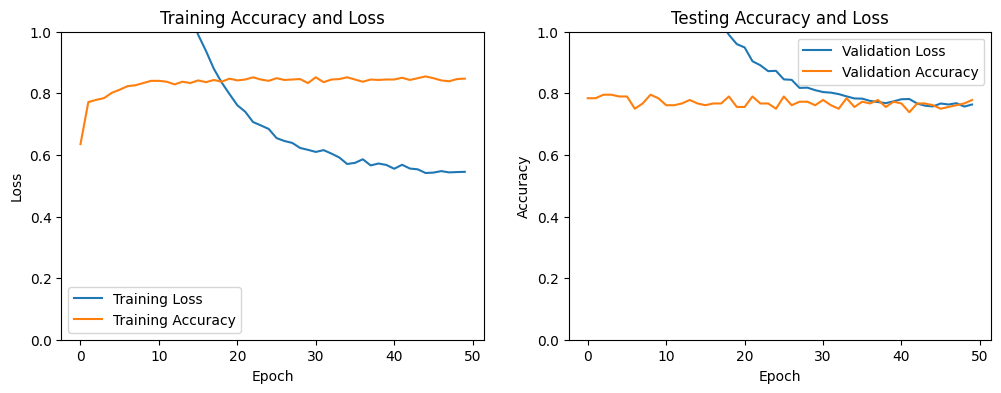

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9227 - loss: 0.3512
Training Accuracy: 0.8807471264367817
Testing Accuracy: 0.7784090909090909
AUROC: 0.7458393511300072
AUPRC: 0.3572869813174405
MAE:  0.11079545454545456

Basic Metrics:
Training Accuracy: 0.8520
Testing Accuracy: 0.7500
F1 Score (weighted): 0.7277
MSE: 0.1108
MAE: 0.1108

ROC AUC Scores:
Macro One vs Rest: 0.7458
Micro One vs Rest: 0.9338
Weighted One vs Rest: 0.8066
One vs One: 0.6242

Precision-Recall AUC Scores:
Macro Average: 0.3573
Micro Average: 0.8549
Weighted Average: 0.7846

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       138
           1       0.29      0.18      0.22        22
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2

   micro avg       0.78      0.78      0.78       176
   macro avg       0.28      0.29      0.28       176
weighted avg       0.69      0.78 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


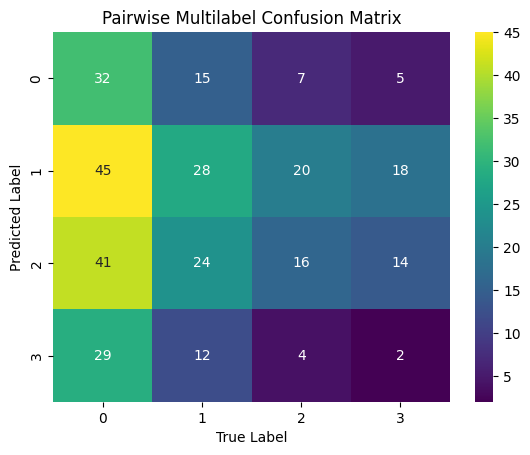

In [50]:
# Define input layer
inputs = keras.Input(shape=(combined_features_train.shape[1],))

regularizer = l1_l2(l1=0.001, l2=0.01)

processed = Dense(128, activation='relu', kernel_regularizer=regularizer)(inputs)
processed = Dropout(0.5)(processed)
processed = Dense(64, activation='relu', kernel_regularizer=regularizer)(processed)
output = Dense(num_classes, activation='softmax')(processed)  # Output layer

# Create the model
final_classifier = keras.Model(inputs=inputs, outputs=output)

# Compile the model
final_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model checkpoint callback
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_model_final_classifier.keras',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
history_final_model = final_classifier.fit(combined_features_train, y_train_categorical, epochs=50, batch_size=64, callbacks=[model_checkpoint], validation_data=(combined_features_test, y_test_categorical))

# Make predictions
y_pred_probs = final_classifier.predict(combined_features_test)
y_pred = np.argmax(y_pred_probs, axis=1)
#one-hot encode y_pred
y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=num_classes)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_final_model.history['loss'], label='Training Loss')
plt.plot(history_final_model.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()
plt.title('Training Accuracy and Loss')

plt.subplot(1, 2, 2)
plt.plot(history_final_model.history['val_loss'], label='Validation Loss')
plt.plot(history_final_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.title('Testing Accuracy and Loss')

plt.show()

#Training accuracy
y_train_categorical_1d = y_train_categorical[:, 1]
train_acc = final_classifier.evaluate(combined_features_train,
y_train_categorical)[1]

print(f'Training Accuracy: {train_accuracy}')

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred)
print(f'Testing Accuracy: {accuracy}')

f1 = f1_score(y_test_categorical, y_pred, average='weighted')
mse = mean_squared_error(y_test_categorical, y_pred)
mae = mean_absolute_error(y_test_categorical, y_pred)

auroc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
auprc = average_precision_score(y_test, y_pred_probs)

roc_macro = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='macro')
roc_micro = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='micro')
roc_weighted = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')
roc_ovo = roc_auc_score(y_test, y_pred_probs, multi_class='ovo')

# Precision-Recall metrics
pr_macro = average_precision_score(y_test, y_pred_probs, average='macro')
pr_micro = average_precision_score(y_test, y_pred_probs, average='micro')
pr_weighted = average_precision_score(y_test, y_pred_probs, average='weighted')
print("AUROC:", auroc)
print("AUPRC:", auprc)
print("MAE: ", mae)

# Print all metrics
print(f"\nBasic Metrics:")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {acc:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")

print(f"\nROC AUC Scores:")
print(f"Macro One vs Rest: {roc_macro:.4f}")
print(f"Micro One vs Rest: {roc_micro:.4f}")
print(f"Weighted One vs Rest: {roc_weighted:.4f}")
print(f"One vs One: {roc_ovo:.4f}")

print(f"\nPrecision-Recall AUC Scores:")
print(f"Macro Average: {pr_macro:.4f}")
print(f"Micro Average: {pr_micro:.4f}")
print(f"Weighted Average: {pr_weighted:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_categorical, y_pred))

# Calculate confusion matrices for each label
mcm = multilabel_confusion_matrix(y_test_categorical, y_pred)

n_labels = len(mcm)
pairwise_cm = np.zeros((n_labels, n_labels))

for i in range(n_labels):
    for j in range(n_labels):
        pairwise_cm[i, j] = mcm[i][1, 0] + mcm[j][0, 1]  # FP of i + FN of j

plt.figure()
sns.heatmap(
    pairwise_cm,
    annot=True,
    cmap='viridis',
    xticklabels=range(n_labels),
    yticklabels=range(n_labels)
    )
plt.title('Pairwise Multilabel Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

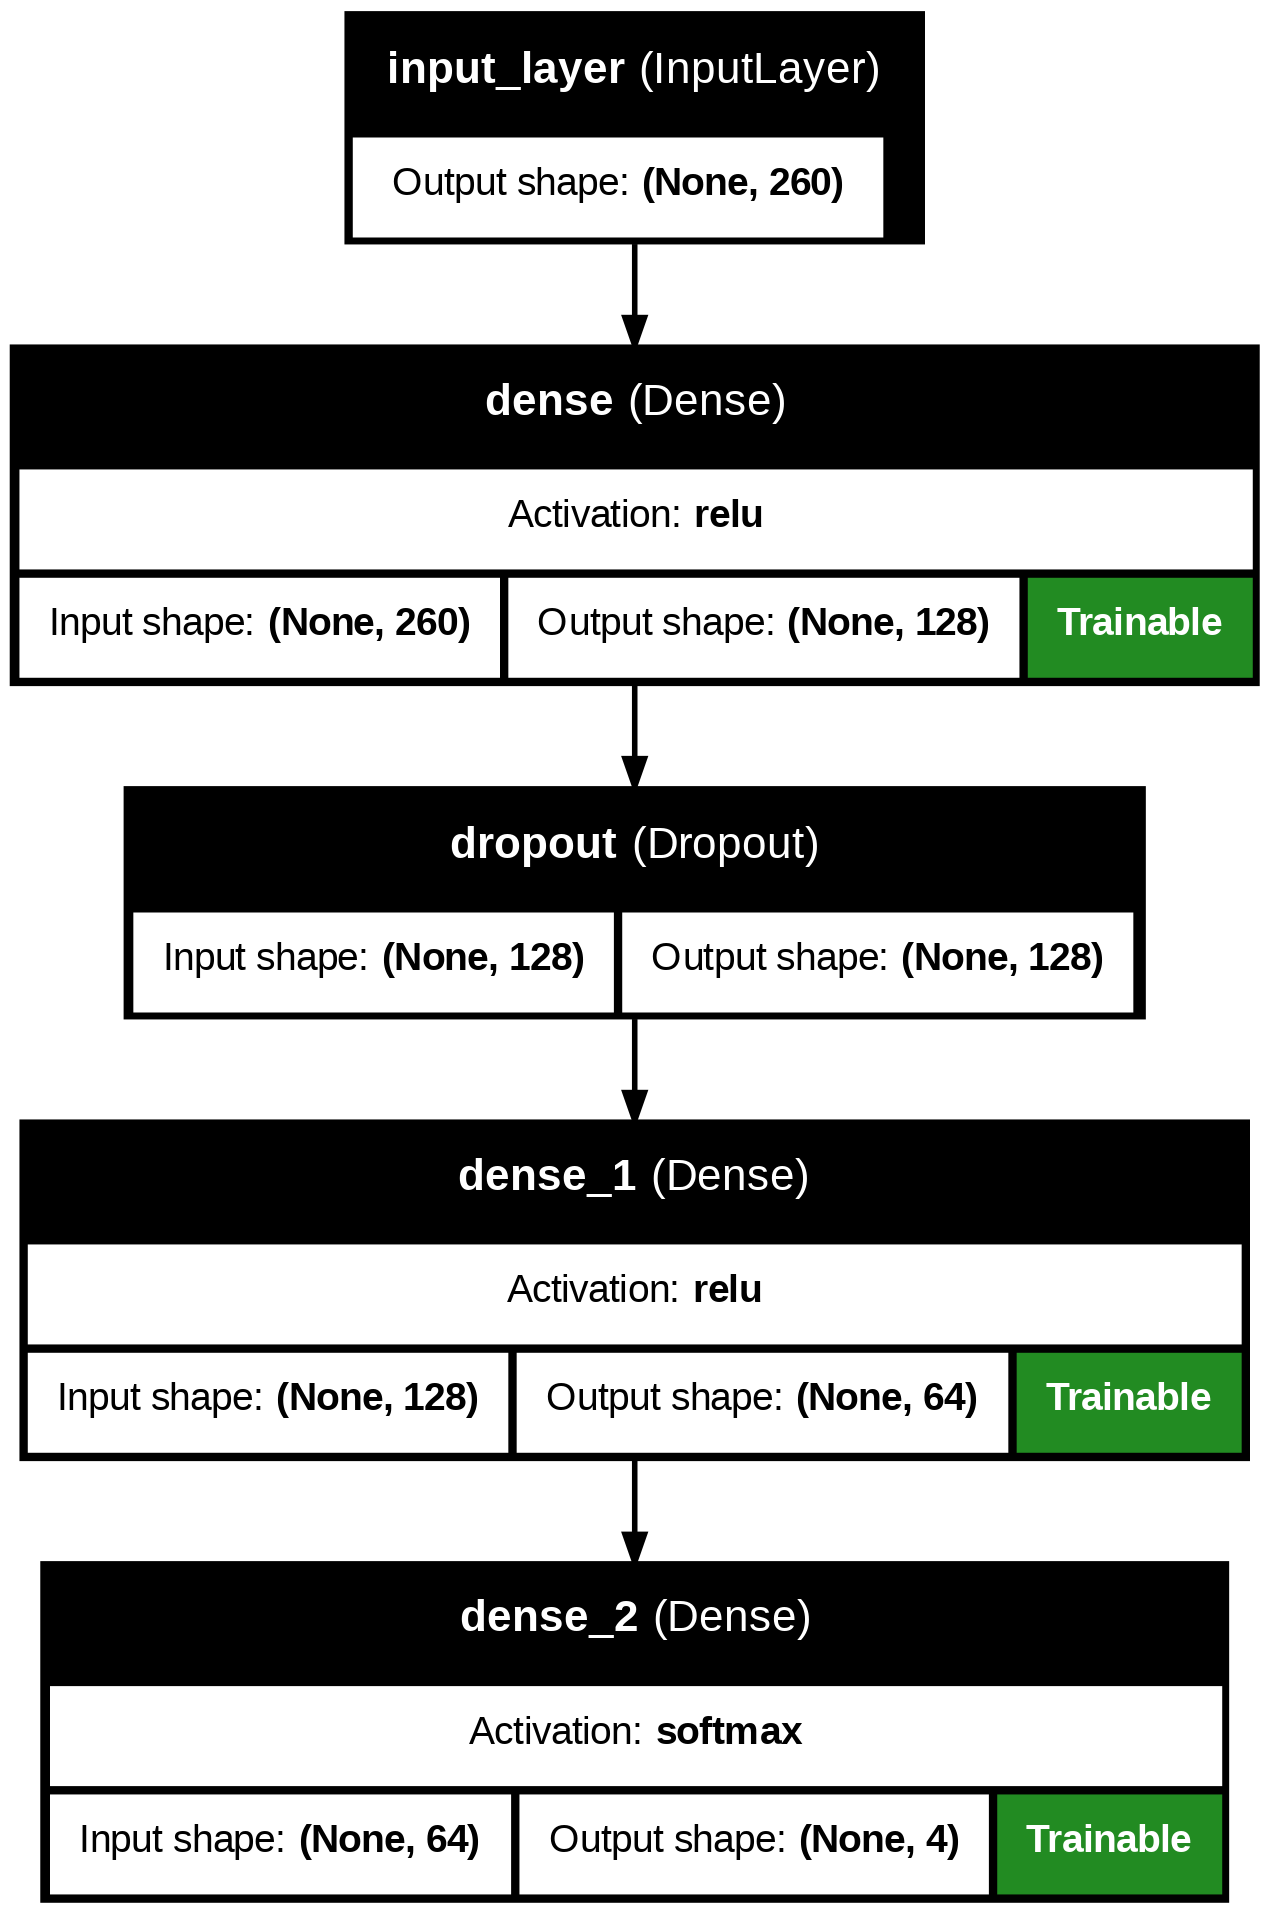

In [51]:
keras.utils.plot_model(final_classifier, to_file='/content/drive/MyDrive/419a files/cnn_model/final_model_classifier.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True, rankdir='TB')

# Ensemble Gate

In [52]:
cnn_weight = final_model.predict(X_test)[:, 0]
xgb_weight = xgb_model.predict(X_test_xgb, output_margin=True)[:, 1]
xgb_weight = scipy.special.expit(xgb_weight)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [53]:
cnn_predictions = final_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test_xgb, output_margin=True)
xgb_predictions = scipy.special.expit(xgb_predictions)

# Weighted average of predictions
final_predictions = (cnn_weight[:, np.newaxis] * cnn_predictions) + (xgb_weight[:, np.newaxis] * xgb_predictions)
# Get final predicted class labels
y_pred = np.argmax(final_predictions, axis=1)
# Convert to one-hot encoding
y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=num_classes)
y_pred_probs = final_predictions[:, 1]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8991 - loss: 6.4358
Training Accuracy: 0.8074712753295898
Testing Accuracy: 0.6931818181818182
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       138
           1       0.22      0.36      0.27        22
           2       0.18      0.14      0.16        14
           3       0.00      0.00      0.00         2

   micro avg       0.69      0.69      0.69       176
   macro avg       0.32      0.33      0.32       176
weighted avg       0.73      0.69      0.71       176
 samples avg       0.69      0.69      0.69       176

AUROC: 0.5816459792432332
AUPRC: 0.2803903034881296
MAE:  0.1534090909090909
F1 Score (weighted):  0.7069126591517313


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


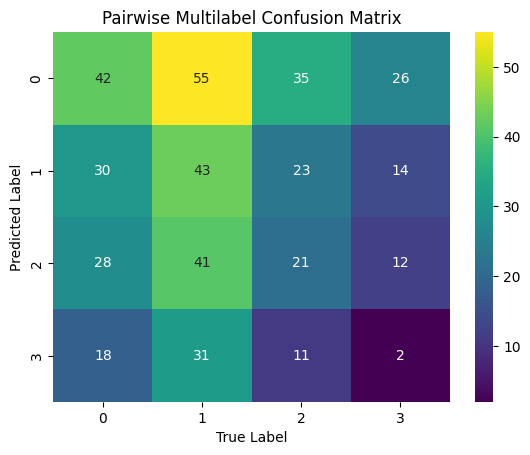

In [54]:
train_accuracy = final_model.evaluate(X_train, y_train_categorical)[1]
print(f'Training Accuracy: {train_accuracy}')
accuracy = accuracy_score(y_test_categorical, y_pred)
print(f'Testing Accuracy: {accuracy}')

# Print classification report for detailed metrics (precision, recall, F1-score)
print(classification_report(y_test_categorical, y_pred))

auroc = roc_auc_score(y_test_categorical, y_pred, multi_class='ovr')
auprc = average_precision_score(y_test, y_pred)
mae = mean_absolute_error(y_test_categorical, y_pred)
f1 = f1_score(y_test_categorical, y_pred, average='weighted')
print("AUROC:", auroc)
print("AUPRC:", auprc)
print("MAE: ", mae)
print("F1 Score (weighted): ", f1)


# Calculate confusion matrices for each label
mcm = multilabel_confusion_matrix(y_test_categorical, y_pred)

n_labels = len(mcm)
pairwise_cm = np.zeros((n_labels, n_labels))

for i in range(n_labels):
    for j in range(n_labels):
        pairwise_cm[i, j] = mcm[i][1, 0] + mcm[j][0, 1]  # FP of i + FN of j

plt.figure()
sns.heatmap(
    pairwise_cm,
    annot=True,
    cmap='viridis',
    xticklabels=range(n_labels),
    yticklabels=range(n_labels)
    )
plt.title('Pairwise Multilabel Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()